In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=1)
output_dir = './output_lambda=10.0'
lambda_ = 10.0

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', output_dir, '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [20]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [21]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [22]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [23]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Gate 付き Transformer の実装と実体化

In [24]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0):
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates).fill_(init))
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5):
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.gate = BinaryGate(num_gates=n_head, init=2.0)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        bin_mask, l0_loss, sparsity = self.gate()
        bin_mask = torch.cat([bin_mask[i].repeat(self.d_model//self.n_head) for i in range(self.n_head)])
        
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q *= bin_mask
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn, l0_loss, sparsity


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn, l0_loss, sparsity = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        
        return enc_output, enc_slf_attn, l0_loss, sparsity


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn, l0_loss1, sparsity1 = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn, l0_loss2, sparsity2 = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        
        return dec_output, dec_slf_attn, dec_enc_attn, l0_loss1+l0_loss2, sparsity1, sparsity2

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        l0_loss = 0.0
        sparsity = [0, 0]
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn, l0, spa = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            l0_loss += l0
            sparsity[0] += spa[0]
            sparsity[1] += spa[1]

        if return_attns:
            return enc_output, l0_loss, sparsity, enc_slf_attn_list
        return enc_output, l0_loss, sparsity,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        l0_loss = 0.0
        sparsity1 = [0, 0]
        sparsity2 = [0, 0]
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn, l0, spa1, spa2 = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
            l0_loss += l0
            sparsity1[0] += spa1[0]
            sparsity1[1] += spa1[1]
            sparsity2[0] += spa2[0]
            sparsity2[1] += spa2[1]

        if return_attns:
            return dec_output, l0_loss, sparsity1, sparsity2, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, l0_loss, sparsity1, sparsity2,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, l0_loss1, sparsity1, *_ = self.encoder(src_seq, src_mask)
        dec_output, l0_loss2, sparsity2, sparsity3, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2)), l0_loss1+l0_loss2, (sparsity1, sparsity2, sparsity3)

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
class ScheduledOptim():

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [32]:
optimizer = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)

# 訓練と検証

In [33]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing, lambda_):

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    enc_sparsity = [0, 0]
    dec_sparsity1 = [0, 0]
    dec_sparsity2 = [0, 0]
    
    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred, l0_loss, sparsity = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing)
        loss_ = loss + lambda_ * l0_loss
        loss_.backward()
        optimizer.step_and_update_lr()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        enc_sparsity[0] += sparsity[0][0]
        enc_sparsity[1] += sparsity[0][1]
        dec_sparsity1[0] += sparsity[1][0]
        dec_sparsity1[1] += sparsity[1][1]
        dec_sparsity2[0] += sparsity[2][0]
        dec_sparsity2[1] += sparsity[2][1]
        

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy, (enc_sparsity, dec_sparsity1, dec_sparsity2)


def eval_epoch(model, validation_data, device, opt, lambda_):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred, l0_loss, sparsity = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [34]:
def train(model, training_data, validation_data, optimizer, device, opt, lambda_=0.0):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')
    log_sparsity_file = os.path.join(opt.output_dir, 'sparsity.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file, log_sparsity_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf, open(log_sparsity_file, 'w') as log_sf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')
        log_sf.write('epoch,enc-sa,dec-sa, dec-enc\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu, sparsity = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing, lambda_=lambda_)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt, lambda_=lambda_)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf, open(log_sparsity_file, 'a') as log_sf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))
            log_sf.write('{epoch},{enc: 3.3f},{dec1: 3.3f},{dec2: 3.3f}\n'.format(
                epoch=epoch_i, 
                enc =(sparsity[0][1]-sparsity[0][0])/sparsity[0][1],
                dec1=(sparsity[1][1]-sparsity[1][0])/sparsity[1][1],
                dec2=(sparsity[2][1]-sparsity[2][0])/sparsity[2][1]))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [35]:
train(transformer, training_data, validation_data, optimizer, device, opt, lambda_=lambda_)

[Info] Training performance will be written to file: ./output_lambda=10.0/train.log and ./output_lambda=10.0/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9500.33826, accuracy: 0.006 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  9474.57718, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9484.22100, accuracy: 0.012 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  9435.46182, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9453.71184, accuracy: 0.848 %, lr:  0.00000, elapse: 0.307 min


  - (Validation) ppl:  9377.63548, accuracy: 11.981 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  9412.59618, accuracy: 6.186 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  9315.28115, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  9361.59024, accuracy: 11.625 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9256.47094, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  9316.18397, accuracy: 11.957 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  9202.75087, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  9271.09247, accuracy: 12.014 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  9155.00722, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9233.23838, accuracy: 12.015 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  9114.49368, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  9198.37593, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  9078.45125, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9164.51258, accuracy: 12.015 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  9043.89195, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9132.23386, accuracy: 12.015 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  9012.63556, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 11 ]


  - (Training)   ppl:  9102.60194, accuracy: 12.015 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  8982.85033, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  9071.91020, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8953.86836, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]


  - (Training)   ppl:  9044.64769, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8925.93602, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]


  - (Training)   ppl:  9017.21016, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8897.96566, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]


  - (Training)   ppl:  8988.09261, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8869.34393, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 16 ]


  - (Training)   ppl:  8962.55160, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8840.30248, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 17 ]


  - (Training)   ppl:  8932.18473, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8809.66630, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  8902.71441, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8777.21759, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 19 ]


  - (Training)   ppl:  8870.90454, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8742.37173, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 20 ]


  - (Training)   ppl:  8839.28486, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8704.39530, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 21 ]


  - (Training)   ppl:  8802.45385, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8661.31277, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 22 ]


  - (Training)   ppl:  8761.00429, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8614.55089, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  8719.33846, accuracy: 12.016 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8565.97192, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 24 ]


  - (Training)   ppl:  8674.87442, accuracy: 12.157 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8517.06554, accuracy: 13.850 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 25 ]


  - (Training)   ppl:  8628.31526, accuracy: 13.388 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  8463.38170, accuracy: 16.309 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 26 ]


  - (Training)   ppl:  8581.30333, accuracy: 15.125 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8407.19063, accuracy: 16.461 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 27 ]


  - (Training)   ppl:  8534.70741, accuracy: 15.923 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8361.95907, accuracy: 16.205 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 28 ]


  - (Training)   ppl:  8488.03227, accuracy: 16.332 %, lr:  0.00000, elapse: 0.320 min


  - (Validation) ppl:  8302.39997, accuracy: 17.168 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 29 ]


  - (Training)   ppl:  8439.31535, accuracy: 16.595 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  8249.78799, accuracy: 17.639 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 30 ]


  - (Training)   ppl:  8391.87056, accuracy: 16.762 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  8197.11026, accuracy: 17.431 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 31 ]


  - (Training)   ppl:  8343.37486, accuracy: 16.922 %, lr:  0.00000, elapse: 0.320 min


  - (Validation) ppl:  8140.35690, accuracy: 17.756 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 32 ]


  - (Training)   ppl:  8293.53518, accuracy: 16.968 %, lr:  0.00000, elapse: 0.321 min


  - (Validation) ppl:  8090.43056, accuracy: 17.729 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 33 ]


  - (Training)   ppl:  8242.89551, accuracy: 17.074 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8029.69648, accuracy: 17.701 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 34 ]


  - (Training)   ppl:  8191.60368, accuracy: 16.933 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7969.78915, accuracy: 18.179 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 35 ]


  - (Training)   ppl:  8136.83943, accuracy: 17.066 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7912.78358, accuracy: 17.791 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 36 ]


  - (Training)   ppl:  8081.84490, accuracy: 17.116 %, lr:  0.00000, elapse: 0.327 min


  - (Validation) ppl:  7846.97194, accuracy: 17.832 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 37 ]


  - (Training)   ppl:  8026.67678, accuracy: 17.037 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  7784.77116, accuracy: 17.881 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 38 ]


  - (Training)   ppl:  7969.52667, accuracy: 17.089 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7722.87121, accuracy: 18.352 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 39 ]


  - (Training)   ppl:  7910.70667, accuracy: 17.081 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  7657.86429, accuracy: 17.562 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]


  - (Training)   ppl:  7850.75076, accuracy: 16.970 %, lr:  0.00000, elapse: 0.322 min


  - (Validation) ppl:  7589.42059, accuracy: 18.186 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 41 ]


  - (Training)   ppl:  7790.44193, accuracy: 17.000 %, lr:  0.00000, elapse: 0.325 min


  - (Validation) ppl:  7521.61710, accuracy: 17.971 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 42 ]


  - (Training)   ppl:  7728.70546, accuracy: 16.857 %, lr:  0.00000, elapse: 0.331 min


  - (Validation) ppl:  7453.47164, accuracy: 17.832 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 43 ]


  - (Training)   ppl:  7665.30723, accuracy: 16.889 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  7384.58306, accuracy: 18.075 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 44 ]


  - (Training)   ppl:  7600.97500, accuracy: 16.837 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7316.75474, accuracy: 18.546 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 45 ]


  - (Training)   ppl:  7536.08845, accuracy: 16.640 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  7242.44974, accuracy: 18.130 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 46 ]


  - (Training)   ppl:  7469.22290, accuracy: 16.544 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  7167.02234, accuracy: 17.071 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 47 ]


  - (Training)   ppl:  7401.77123, accuracy: 16.478 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  7093.93280, accuracy: 16.343 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 48 ]


  - (Training)   ppl:  7334.27017, accuracy: 16.439 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  7017.91416, accuracy: 17.175 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 49 ]


  - (Training)   ppl:  7264.68366, accuracy: 16.517 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  6941.83687, accuracy: 17.562 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 50 ]


  - (Training)   ppl:  7194.20921, accuracy: 16.254 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  6864.91458, accuracy: 17.597 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 51 ]


  - (Training)   ppl:  7124.27390, accuracy: 16.156 %, lr:  0.00001, elapse: 0.324 min


  - (Validation) ppl:  6788.02381, accuracy: 17.569 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 52 ]


  - (Training)   ppl:  7051.87346, accuracy: 15.980 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6711.14093, accuracy: 17.936 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 53 ]


  - (Training)   ppl:  6978.69240, accuracy: 15.932 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  6631.03950, accuracy: 17.410 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 54 ]


  - (Training)   ppl:  6906.38175, accuracy: 15.823 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6551.50068, accuracy: 17.535 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 55 ]


  - (Training)   ppl:  6833.03600, accuracy: 15.810 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6471.01808, accuracy: 16.496 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 56 ]


  - (Training)   ppl:  6758.50076, accuracy: 15.664 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  6390.69777, accuracy: 15.970 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 57 ]


  - (Training)   ppl:  6684.04351, accuracy: 15.376 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6312.48769, accuracy: 13.864 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 58 ]


  - (Training)   ppl:  6608.81850, accuracy: 15.046 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  6228.52013, accuracy: 16.385 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 59 ]


  - (Training)   ppl:  6531.81271, accuracy: 15.007 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6146.56564, accuracy: 16.330 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 60 ]


  - (Training)   ppl:  6455.39291, accuracy: 14.845 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  6063.23855, accuracy: 15.616 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 61 ]


  - (Training)   ppl:  6377.90742, accuracy: 14.719 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5981.21422, accuracy: 15.699 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 62 ]


  - (Training)   ppl:  6302.07871, accuracy: 14.428 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5898.55363, accuracy: 15.637 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 63 ]


  - (Training)   ppl:  6223.61105, accuracy: 14.309 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  5814.92559, accuracy: 13.934 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 64 ]


  - (Training)   ppl:  6145.48518, accuracy: 14.154 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  5732.40878, accuracy: 13.954 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 65 ]


  - (Training)   ppl:  6067.22156, accuracy: 13.937 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5648.62516, accuracy: 13.726 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 66 ]


  - (Training)   ppl:  5989.30435, accuracy: 13.729 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5566.13387, accuracy: 13.186 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 67 ]


  - (Training)   ppl:  5911.23631, accuracy: 13.450 %, lr:  0.00001, elapse: 0.327 min


  - (Validation) ppl:  5482.19942, accuracy: 13.310 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 68 ]


  - (Training)   ppl:  5831.93755, accuracy: 13.315 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  5398.51268, accuracy: 12.846 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 69 ]


  - (Training)   ppl:  5753.12665, accuracy: 13.139 %, lr:  0.00001, elapse: 0.328 min


  - (Validation) ppl:  5316.36805, accuracy: 12.729 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 70 ]


  - (Training)   ppl:  5673.64239, accuracy: 12.969 %, lr:  0.00001, elapse: 0.328 min


  - (Validation) ppl:  5231.81496, accuracy: 12.133 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 71 ]


  - (Training)   ppl:  5595.04945, accuracy: 12.782 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5148.66930, accuracy: 12.846 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 72 ]


  - (Training)   ppl:  5517.06311, accuracy: 12.653 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5066.82720, accuracy: 12.071 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 73 ]


  - (Training)   ppl:  5436.87496, accuracy: 12.534 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4985.01962, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 74 ]


  - (Training)   ppl:  5358.84292, accuracy: 12.485 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4900.80612, accuracy: 12.022 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 75 ]


  - (Training)   ppl:  5279.57841, accuracy: 12.372 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4818.39194, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 76 ]


  - (Training)   ppl:  5201.40361, accuracy: 12.315 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  4736.66145, accuracy: 12.015 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 77 ]


  - (Training)   ppl:  5122.42346, accuracy: 12.243 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4656.17747, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 78 ]


  - (Training)   ppl:  5044.17320, accuracy: 12.164 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4574.28098, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 79 ]


  - (Training)   ppl:  4966.48195, accuracy: 12.160 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  4493.38611, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 80 ]


  - (Training)   ppl:  4888.92108, accuracy: 12.084 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4412.37107, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 81 ]


  - (Training)   ppl:  4811.63545, accuracy: 12.102 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  4334.21760, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 82 ]


  - (Training)   ppl:  4734.04191, accuracy: 12.055 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  4254.00389, accuracy: 12.001 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 83 ]


  - (Training)   ppl:  4657.17965, accuracy: 12.056 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4175.29956, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 84 ]


  - (Training)   ppl:  4581.22848, accuracy: 12.045 %, lr:  0.00001, elapse: 0.319 min


  - (Validation) ppl:  4096.38326, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 85 ]


  - (Training)   ppl:  4505.27760, accuracy: 12.034 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4019.26949, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 86 ]


  - (Training)   ppl:  4429.89247, accuracy: 12.023 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  3942.83082, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 87 ]


  - (Training)   ppl:  4354.87930, accuracy: 12.020 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  3865.94518, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 88 ]


  - (Training)   ppl:  4280.35441, accuracy: 12.024 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3790.14457, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 89 ]


  - (Training)   ppl:  4206.30687, accuracy: 12.021 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3715.37689, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 90 ]


  - (Training)   ppl:  4133.13421, accuracy: 12.018 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3640.73855, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 91 ]


  - (Training)   ppl:  4060.33920, accuracy: 12.017 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3568.98191, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 92 ]


  - (Training)   ppl:  3987.66127, accuracy: 12.016 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3495.95269, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 93 ]


  - (Training)   ppl:  3916.02859, accuracy: 12.016 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  3423.71292, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 94 ]


  - (Training)   ppl:  3845.05486, accuracy: 12.016 %, lr:  0.00001, elapse: 0.323 min


  - (Validation) ppl:  3352.67113, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 95 ]


  - (Training)   ppl:  3774.67445, accuracy: 12.015 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  3282.29092, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 96 ]


  - (Training)   ppl:  3704.78521, accuracy: 12.015 %, lr:  0.00001, elapse: 0.327 min


  - (Validation) ppl:  3213.15084, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 97 ]


  - (Training)   ppl:  3635.68011, accuracy: 12.015 %, lr:  0.00001, elapse: 0.327 min


  - (Validation) ppl:  3144.49899, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 98 ]


  - (Training)   ppl:  3567.08505, accuracy: 12.015 %, lr:  0.00001, elapse: 0.332 min


  - (Validation) ppl:  3076.96684, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 99 ]


  - (Training)   ppl:  3499.45542, accuracy: 12.015 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  3009.63992, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 100 ]


  - (Training)   ppl:  3432.31956, accuracy: 12.015 %, lr:  0.00001, elapse: 0.327 min


  - (Validation) ppl:  2945.64144, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 101 ]


  - (Training)   ppl:  3366.56208, accuracy: 12.015 %, lr:  0.00001, elapse: 0.327 min


  - (Validation) ppl:  2879.27680, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 102 ]


  - (Training)   ppl:  3300.96370, accuracy: 12.015 %, lr:  0.00001, elapse: 0.327 min


  - (Validation) ppl:  2814.99972, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 103 ]


  - (Training)   ppl:  3236.44411, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2752.45464, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 104 ]


  - (Training)   ppl:  3172.85456, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2690.58801, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 105 ]


  - (Training)   ppl:  3109.20845, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  2628.55071, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 106 ]


  - (Training)   ppl:  3047.21353, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  2568.52461, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 107 ]


  - (Training)   ppl:  2985.78130, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2508.31835, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 108 ]


  - (Training)   ppl:  2924.91988, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2450.35241, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 109 ]


  - (Training)   ppl:  2865.14908, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2393.05334, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 110 ]


  - (Training)   ppl:  2806.17769, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  2336.87983, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 111 ]


  - (Training)   ppl:  2748.09201, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  2280.94609, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 112 ]


  - (Training)   ppl:  2690.73784, accuracy: 12.015 %, lr:  0.00001, elapse: 0.322 min


  - (Validation) ppl:  2227.18242, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 113 ]


  - (Training)   ppl:  2634.57600, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2173.30690, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 114 ]


  - (Training)   ppl:  2578.63479, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  2120.67612, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 115 ]


  - (Training)   ppl:  2524.02621, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2070.31766, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 116 ]


  - (Training)   ppl:  2470.19410, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2018.48263, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 117 ]


  - (Training)   ppl:  2417.26495, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1969.38384, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 118 ]


  - (Training)   ppl:  2364.98859, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1920.12941, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 119 ]


  - (Training)   ppl:  2313.70678, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  1872.94568, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 120 ]


  - (Training)   ppl:  2263.52375, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1824.62329, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 121 ]


  - (Training)   ppl:  2213.84181, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1778.81177, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 122 ]


  - (Training)   ppl:  2165.33954, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1734.33529, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 123 ]


  - (Training)   ppl:  2117.49761, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1689.98997, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 124 ]


  - (Training)   ppl:  2070.57768, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1646.55000, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 125 ]


  - (Training)   ppl:  2024.37224, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1604.63721, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 126 ]


  - (Training)   ppl:  1979.50110, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  1564.33669, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 127 ]


  - (Training)   ppl:  1934.96631, accuracy: 12.015 %, lr:  0.00001, elapse: 0.327 min


  - (Validation) ppl:  1523.15959, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 128 ]


  - (Training)   ppl:  1891.82017, accuracy: 12.015 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  1483.53505, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 129 ]


  - (Training)   ppl:  1848.83749, accuracy: 12.015 %, lr:  0.00001, elapse: 0.326 min


  - (Validation) ppl:  1444.75176, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 130 ]


  - (Training)   ppl:  1807.07531, accuracy: 12.015 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  1407.73046, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 131 ]


  - (Training)   ppl:  1765.99567, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1370.83284, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 132 ]


  - (Training)   ppl:  1725.94163, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1334.42467, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 133 ]


  - (Training)   ppl:  1686.63864, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1299.31242, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 134 ]


  - (Training)   ppl:  1648.17229, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1264.89615, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 135 ]


  - (Training)   ppl:  1610.61372, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  1231.61005, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 136 ]


  - (Training)   ppl:  1573.68845, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1199.78135, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 137 ]


  - (Training)   ppl:  1537.63883, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  1167.44234, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 138 ]


  - (Training)   ppl:  1502.30328, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  1136.20981, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 139 ]


  - (Training)   ppl:  1467.68122, accuracy: 12.015 %, lr:  0.00002, elapse: 0.333 min


  - (Validation) ppl:  1106.28110, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 140 ]


  - (Training)   ppl:  1433.97552, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  1076.67461, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 141 ]


  - (Training)   ppl:  1401.03469, accuracy: 12.015 %, lr:  0.00002, elapse: 0.328 min


  - (Validation) ppl:  1047.65894, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 142 ]


  - (Training)   ppl:  1368.83868, accuracy: 12.015 %, lr:  0.00002, elapse: 0.330 min


  - (Validation) ppl:  1020.33650, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 143 ]


  - (Training)   ppl:  1337.18400, accuracy: 12.015 %, lr:  0.00002, elapse: 0.328 min


  - (Validation) ppl:  992.80231, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 144 ]


  - (Training)   ppl:  1306.52454, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  966.04459, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 145 ]


  - (Training)   ppl:  1276.24787, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  940.01974, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 146 ]


  - (Training)   ppl:  1246.94964, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  915.36010, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 147 ]


  - (Training)   ppl:  1218.29712, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  890.44530, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 148 ]


  - (Training)   ppl:  1190.22855, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  866.74189, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 149 ]


  - (Training)   ppl:  1162.86614, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  843.18667, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 150 ]


  - (Training)   ppl:  1136.26480, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  820.75770, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 151 ]


  - (Training)   ppl:  1110.32020, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  798.98478, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 152 ]


  - (Training)   ppl:  1084.92026, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  777.70319, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 153 ]


  - (Training)   ppl:  1060.27865, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  757.07610, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 154 ]


  - (Training)   ppl:  1036.11980, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  736.78202, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 155 ]


  - (Training)   ppl:  1012.69507, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  717.35826, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 156 ]


  - (Training)   ppl:  989.82652, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  698.25124, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 157 ]


  - (Training)   ppl:  967.50704, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  679.69965, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 158 ]


  - (Training)   ppl:  945.88793, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  661.81871, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 159 ]


  - (Training)   ppl:  924.76441, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  644.45314, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 160 ]


  - (Training)   ppl:  904.35858, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  627.71251, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  884.33430, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  611.30734, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 162 ]


  - (Training)   ppl:  864.89077, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  595.42063, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 163 ]


  - (Training)   ppl:  846.01258, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  580.00028, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 164 ]


  - (Training)   ppl:  827.67827, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  565.08797, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 165 ]


  - (Training)   ppl:  809.91064, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  550.89174, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 166 ]


  - (Training)   ppl:  792.59257, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  536.77488, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 167 ]


  - (Training)   ppl:  775.81818, accuracy: 12.015 %, lr:  0.00002, elapse: 0.320 min


  - (Validation) ppl:  523.28725, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 168 ]


  - (Training)   ppl:  759.48182, accuracy: 12.015 %, lr:  0.00002, elapse: 0.322 min


  - (Validation) ppl:  510.16226, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 169 ]


  - (Training)   ppl:  743.58273, accuracy: 12.015 %, lr:  0.00002, elapse: 0.322 min


  - (Validation) ppl:  497.48758, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 170 ]


  - (Training)   ppl:  728.17144, accuracy: 12.015 %, lr:  0.00002, elapse: 0.326 min


  - (Validation) ppl:  485.16230, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 171 ]


  - (Training)   ppl:  713.29651, accuracy: 12.015 %, lr:  0.00002, elapse: 0.328 min


  - (Validation) ppl:  473.33761, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 172 ]


  - (Training)   ppl:  698.86117, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  461.90395, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 173 ]


  - (Training)   ppl:  684.74054, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  450.69319, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 174 ]


  - (Training)   ppl:  671.10098, accuracy: 12.015 %, lr:  0.00002, elapse: 0.324 min


  - (Validation) ppl:  439.98323, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 175 ]


  - (Training)   ppl:  657.92404, accuracy: 12.015 %, lr:  0.00002, elapse: 0.327 min


  - (Validation) ppl:  429.57982, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 176 ]


  - (Training)   ppl:  645.06777, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  419.46382, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 177 ]


  - (Training)   ppl:  632.65802, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  409.69242, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 178 ]


  - (Training)   ppl:  620.62891, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  400.29871, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 179 ]


  - (Training)   ppl:  609.02261, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  391.28388, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 180 ]


  - (Training)   ppl:  597.66440, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  382.43544, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 181 ]


  - (Training)   ppl:  586.77703, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  373.98301, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 182 ]


  - (Training)   ppl:  576.23765, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  365.76508, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 183 ]


  - (Training)   ppl:  566.05667, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  357.92549, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 184 ]


  - (Training)   ppl:  556.16066, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  350.28738, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 185 ]


  - (Training)   ppl:  546.64584, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  342.96587, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 186 ]


  - (Training)   ppl:  537.47592, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  335.83209, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 187 ]


  - (Training)   ppl:  528.60619, accuracy: 12.015 %, lr:  0.00002, elapse: 0.327 min


  - (Validation) ppl:  329.05929, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 188 ]


  - (Training)   ppl:  520.08105, accuracy: 12.015 %, lr:  0.00002, elapse: 0.327 min


  - (Validation) ppl:  322.48500, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 189 ]


  - (Training)   ppl:  511.84644, accuracy: 12.015 %, lr:  0.00002, elapse: 0.328 min


  - (Validation) ppl:  316.17838, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 190 ]


  - (Training)   ppl:  503.92921, accuracy: 12.015 %, lr:  0.00002, elapse: 0.334 min


  - (Validation) ppl:  310.09397, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 191 ]


  - (Training)   ppl:  496.34864, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  304.21683, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 192 ]


  - (Training)   ppl:  489.08825, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  298.64669, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 193 ]


  - (Training)   ppl:  482.09149, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  293.27102, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 194 ]


  - (Training)   ppl:  475.41846, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  288.21782, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 195 ]


  - (Training)   ppl:  469.04592, accuracy: 12.015 %, lr:  0.00002, elapse: 0.320 min


  - (Validation) ppl:  283.25621, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 196 ]


  - (Training)   ppl:  462.89784, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  278.54634, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 197 ]


  - (Training)   ppl:  457.00446, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  273.99208, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 198 ]


  - (Training)   ppl:  451.29982, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  269.77852, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 199 ]


  - (Training)   ppl:  445.85864, accuracy: 12.016 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  265.42283, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 200 ]


  - (Training)   ppl:  440.60124, accuracy: 12.019 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  261.66009, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 201 ]


  - (Training)   ppl:  435.24695, accuracy: 12.041 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  257.37001, accuracy: 12.084 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 202 ]


  - (Training)   ppl:  430.30493, accuracy: 12.066 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  253.73228, accuracy: 12.015 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 203 ]


  - (Training)   ppl:  425.33278, accuracy: 12.105 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  250.76054, accuracy: 12.105 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 204 ]


  - (Training)   ppl:  420.75988, accuracy: 12.144 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  246.28513, accuracy: 12.071 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 205 ]


  - (Training)   ppl:  415.88097, accuracy: 12.200 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  243.16455, accuracy: 12.071 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 206 ]


  - (Training)   ppl:  411.55016, accuracy: 12.219 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  240.03882, accuracy: 12.022 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 207 ]


  - (Training)   ppl:  407.19063, accuracy: 12.266 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  236.39633, accuracy: 12.071 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 208 ]


  - (Training)   ppl:  402.82311, accuracy: 12.289 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  233.39706, accuracy: 12.168 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 209 ]


  - (Training)   ppl:  398.57575, accuracy: 12.321 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  230.36056, accuracy: 12.126 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 210 ]


  - (Training)   ppl:  394.33846, accuracy: 12.358 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  226.98942, accuracy: 12.091 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 211 ]


  - (Training)   ppl:  390.36259, accuracy: 12.386 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  224.11333, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 212 ]


  - (Training)   ppl:  386.36190, accuracy: 12.387 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  221.44493, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 213 ]


  - (Training)   ppl:  382.74323, accuracy: 12.379 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  218.10182, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 214 ]


  - (Training)   ppl:  378.68863, accuracy: 12.380 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  216.24221, accuracy: 12.064 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 215 ]


  - (Training)   ppl:  374.94283, accuracy: 12.424 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  212.41975, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 216 ]


  - (Training)   ppl:  371.18008, accuracy: 12.400 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  210.17802, accuracy: 12.064 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 217 ]


  - (Training)   ppl:  367.55941, accuracy: 12.568 %, lr:  0.00002, elapse: 0.323 min


  - (Validation) ppl:  207.86057, accuracy: 12.022 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 218 ]


  - (Training)   ppl:  363.71114, accuracy: 12.502 %, lr:  0.00002, elapse: 0.327 min


  - (Validation) ppl:  205.73691, accuracy: 12.230 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 219 ]


  - (Training)   ppl:  360.39333, accuracy: 12.746 %, lr:  0.00002, elapse: 0.329 min


  - (Validation) ppl:  203.30969, accuracy: 12.015 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 220 ]


  - (Training)   ppl:  356.89516, accuracy: 12.998 %, lr:  0.00002, elapse: 0.327 min


  - (Validation) ppl:  201.56955, accuracy: 13.476 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 221 ]


  - (Training)   ppl:  352.91578, accuracy: 13.072 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  199.01236, accuracy: 13.705 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 222 ]


  - (Training)   ppl:  349.21803, accuracy: 13.232 %, lr:  0.00002, elapse: 0.326 min


  - (Validation) ppl:  194.81730, accuracy: 12.084 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 223 ]


  - (Training)   ppl:  345.63128, accuracy: 13.436 %, lr:  0.00002, elapse: 0.330 min


  - (Validation) ppl:  194.48814, accuracy: 14.252 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 224 ]


  - (Training)   ppl:  341.76000, accuracy: 13.831 %, lr:  0.00002, elapse: 0.324 min


  - (Validation) ppl:  190.37367, accuracy: 13.532 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 225 ]


  - (Training)   ppl:  338.10621, accuracy: 14.194 %, lr:  0.00002, elapse: 0.329 min


  - (Validation) ppl:  188.75497, accuracy: 15.048 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 226 ]


  - (Training)   ppl:  334.43319, accuracy: 14.666 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  186.61955, accuracy: 14.965 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 227 ]


  - (Training)   ppl:  330.64924, accuracy: 15.052 %, lr:  0.00003, elapse: 0.326 min


  - (Validation) ppl:  183.76908, accuracy: 14.114 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 228 ]


  - (Training)   ppl:  326.76923, accuracy: 15.464 %, lr:  0.00003, elapse: 0.324 min


  - (Validation) ppl:  181.28396, accuracy: 14.737 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 229 ]


  - (Training)   ppl:  323.20256, accuracy: 15.781 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  179.42498, accuracy: 15.686 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 230 ]


  - (Training)   ppl:  319.39825, accuracy: 16.311 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  176.30049, accuracy: 14.945 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 231 ]


  - (Training)   ppl:  315.48166, accuracy: 16.565 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  173.51186, accuracy: 15.886 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 232 ]


  - (Training)   ppl:  311.58681, accuracy: 17.127 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  171.00892, accuracy: 17.126 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 233 ]


  - (Training)   ppl:  307.87788, accuracy: 17.638 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  169.13324, accuracy: 17.542 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 234 ]


  - (Training)   ppl:  303.92759, accuracy: 18.783 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  166.76400, accuracy: 17.521 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 235 ]


  - (Training)   ppl:  300.17946, accuracy: 20.326 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  163.51549, accuracy: 16.330 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 236 ]


  - (Training)   ppl:  296.65852, accuracy: 22.079 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  161.86884, accuracy: 23.615 %, lr:  0.00003, elapse: 0.009 min
    - [Info] The checkpoint file has been updated.
[ Epoch 237 ]


  - (Training)   ppl:  292.99773, accuracy: 23.331 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  159.40474, accuracy: 24.578 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 238 ]


  - (Training)   ppl:  288.96243, accuracy: 24.299 %, lr:  0.00003, elapse: 0.322 min


  - (Validation) ppl:  156.83490, accuracy: 24.612 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 239 ]


  - (Training)   ppl:  285.52902, accuracy: 24.539 %, lr:  0.00003, elapse: 0.325 min


  - (Validation) ppl:  154.90028, accuracy: 24.654 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 240 ]


  - (Training)   ppl:  281.69955, accuracy: 24.733 %, lr:  0.00003, elapse: 0.321 min


  - (Validation) ppl:  151.69341, accuracy: 24.633 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 241 ]


  - (Training)   ppl:  278.20952, accuracy: 24.770 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  150.25728, accuracy: 24.792 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 242 ]


  - (Training)   ppl:  274.01511, accuracy: 24.822 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  148.17712, accuracy: 24.972 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 243 ]


  - (Training)   ppl:  271.10887, accuracy: 24.868 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  145.49689, accuracy: 24.848 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 244 ]


  - (Training)   ppl:  267.27440, accuracy: 24.943 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  142.74743, accuracy: 24.827 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 245 ]


  - (Training)   ppl:  263.57223, accuracy: 25.069 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  142.52560, accuracy: 25.422 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 246 ]


  - (Training)   ppl:  259.97168, accuracy: 25.205 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  139.32776, accuracy: 25.353 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 247 ]


  - (Training)   ppl:  256.22025, accuracy: 25.583 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  137.58747, accuracy: 26.607 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 248 ]


  - (Training)   ppl:  253.08569, accuracy: 26.077 %, lr:  0.00003, elapse: 0.328 min


  - (Validation) ppl:  134.29719, accuracy: 27.258 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 249 ]


  - (Training)   ppl:  249.20014, accuracy: 26.736 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  133.51798, accuracy: 28.137 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 250 ]


  - (Training)   ppl:  245.89604, accuracy: 27.250 %, lr:  0.00003, elapse: 0.322 min


  - (Validation) ppl:  130.92817, accuracy: 28.179 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 251 ]


  - (Training)   ppl:  242.80640, accuracy: 27.670 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  128.97373, accuracy: 28.033 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 252 ]


  - (Training)   ppl:  239.04861, accuracy: 27.979 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  126.36188, accuracy: 28.428 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 253 ]


  - (Training)   ppl:  235.71295, accuracy: 28.185 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  124.16046, accuracy: 28.449 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 254 ]


  - (Training)   ppl:  232.37873, accuracy: 28.320 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  122.45025, accuracy: 28.463 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 255 ]


  - (Training)   ppl:  228.68203, accuracy: 28.460 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  120.68643, accuracy: 28.483 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 256 ]


  - (Training)   ppl:  225.74803, accuracy: 28.532 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  118.65653, accuracy: 28.463 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 257 ]


  - (Training)   ppl:  222.38750, accuracy: 28.585 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  115.94894, accuracy: 28.733 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 258 ]


  - (Training)   ppl:  219.21950, accuracy: 28.640 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  115.30060, accuracy: 28.663 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 259 ]


  - (Training)   ppl:  216.57351, accuracy: 28.664 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  112.21369, accuracy: 28.753 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 260 ]


  - (Training)   ppl:  213.25101, accuracy: 28.713 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  111.34827, accuracy: 28.698 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 261 ]


  - (Training)   ppl:  210.54429, accuracy: 28.715 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  109.32503, accuracy: 28.650 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 262 ]


  - (Training)   ppl:  207.10352, accuracy: 28.789 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  107.12717, accuracy: 28.788 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 263 ]


  - (Training)   ppl:  204.40940, accuracy: 28.795 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  106.17456, accuracy: 28.774 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 264 ]


  - (Training)   ppl:  201.57979, accuracy: 28.827 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  103.54360, accuracy: 28.892 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 265 ]


  - (Training)   ppl:  198.69415, accuracy: 28.904 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  101.29896, accuracy: 28.892 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 266 ]


  - (Training)   ppl:  196.04376, accuracy: 28.886 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  100.65219, accuracy: 28.843 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 267 ]


  - (Training)   ppl:  193.29253, accuracy: 28.939 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  98.60129, accuracy: 29.024 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 268 ]


  - (Training)   ppl:  190.75691, accuracy: 28.945 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  97.23950, accuracy: 28.913 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 269 ]


  - (Training)   ppl:  188.05806, accuracy: 29.015 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  95.46979, accuracy: 28.968 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 270 ]


  - (Training)   ppl:  185.59313, accuracy: 28.996 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  94.75444, accuracy: 28.843 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 271 ]


  - (Training)   ppl:  183.50803, accuracy: 29.019 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  93.45472, accuracy: 29.093 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 272 ]


  - (Training)   ppl:  180.90590, accuracy: 29.051 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  91.65709, accuracy: 29.037 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 273 ]


  - (Training)   ppl:  178.65970, accuracy: 29.089 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  90.26200, accuracy: 29.072 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 274 ]


  - (Training)   ppl:  176.17994, accuracy: 29.127 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  88.61361, accuracy: 29.197 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 275 ]


  - (Training)   ppl:  173.81297, accuracy: 29.170 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  88.14304, accuracy: 29.155 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 276 ]


  - (Training)   ppl:  171.87975, accuracy: 29.178 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  86.18737, accuracy: 29.328 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 277 ]


  - (Training)   ppl:  169.53918, accuracy: 29.231 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  85.35002, accuracy: 29.301 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 278 ]


  - (Training)   ppl:  167.65807, accuracy: 29.247 %, lr:  0.00003, elapse: 0.329 min


  - (Validation) ppl:  83.67953, accuracy: 29.280 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 279 ]


  - (Training)   ppl:  165.47765, accuracy: 29.311 %, lr:  0.00003, elapse: 0.328 min


  - (Validation) ppl:  82.62635, accuracy: 29.612 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 280 ]


  - (Training)   ppl:  163.56256, accuracy: 29.378 %, lr:  0.00003, elapse: 0.326 min


  - (Validation) ppl:  82.23556, accuracy: 29.675 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 281 ]


  - (Training)   ppl:  161.91580, accuracy: 29.437 %, lr:  0.00003, elapse: 0.329 min


  - (Validation) ppl:  80.36360, accuracy: 29.695 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 282 ]


  - (Training)   ppl:  159.42653, accuracy: 29.571 %, lr:  0.00003, elapse: 0.323 min


  - (Validation) ppl:  78.86737, accuracy: 29.675 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 283 ]


  - (Training)   ppl:  157.80291, accuracy: 29.651 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  78.55602, accuracy: 29.647 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 284 ]


  - (Training)   ppl:  156.18934, accuracy: 29.703 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  77.18412, accuracy: 29.972 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 285 ]


  - (Training)   ppl:  154.19351, accuracy: 29.828 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  76.66291, accuracy: 30.048 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 286 ]


  - (Training)   ppl:  152.64761, accuracy: 29.882 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  75.49054, accuracy: 30.118 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 287 ]


  - (Training)   ppl:  151.02153, accuracy: 29.974 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  74.32910, accuracy: 29.945 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 288 ]


  - (Training)   ppl:  149.23918, accuracy: 30.079 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  73.34124, accuracy: 30.180 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 289 ]


  - (Training)   ppl:  147.54012, accuracy: 30.156 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  72.41506, accuracy: 30.332 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 290 ]


  - (Training)   ppl:  145.84814, accuracy: 30.242 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  71.86354, accuracy: 30.416 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 291 ]


  - (Training)   ppl:  144.49722, accuracy: 30.334 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  70.83822, accuracy: 30.540 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 292 ]


  - (Training)   ppl:  143.07901, accuracy: 30.406 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  70.04494, accuracy: 30.561 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 293 ]


  - (Training)   ppl:  141.61186, accuracy: 30.516 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  68.87271, accuracy: 30.596 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 294 ]


  - (Training)   ppl:  140.15028, accuracy: 30.608 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  68.44295, accuracy: 30.519 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 295 ]


  - (Training)   ppl:  139.11890, accuracy: 30.728 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  67.69661, accuracy: 30.533 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 296 ]


  - (Training)   ppl:  137.68060, accuracy: 30.811 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  67.42917, accuracy: 30.796 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 297 ]


  - (Training)   ppl:  136.25945, accuracy: 30.907 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  65.79280, accuracy: 30.935 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 298 ]


  - (Training)   ppl:  134.85271, accuracy: 31.055 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  65.16637, accuracy: 30.983 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 299 ]


  - (Training)   ppl:  133.74026, accuracy: 31.141 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  65.06386, accuracy: 30.900 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 300 ]


  - (Training)   ppl:  132.41742, accuracy: 31.238 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  64.14838, accuracy: 31.392 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 301 ]


  - (Training)   ppl:  131.49860, accuracy: 31.321 %, lr:  0.00003, elapse: 0.324 min


  - (Validation) ppl:  64.24890, accuracy: 31.350 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 302 ]


  - (Training)   ppl:  130.34963, accuracy: 31.407 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  62.95892, accuracy: 31.697 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 303 ]


  - (Training)   ppl:  129.04669, accuracy: 31.526 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  61.99270, accuracy: 31.814 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 304 ]


  - (Training)   ppl:  127.76904, accuracy: 31.657 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  61.96037, accuracy: 31.773 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 305 ]


  - (Training)   ppl:  126.72488, accuracy: 31.751 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  61.27168, accuracy: 31.953 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 306 ]


  - (Training)   ppl:  125.59324, accuracy: 31.843 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  60.27858, accuracy: 32.140 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 307 ]


  - (Training)   ppl:  124.50527, accuracy: 32.001 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  59.76650, accuracy: 32.334 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 308 ]


  - (Training)   ppl:  123.50661, accuracy: 32.055 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  59.72782, accuracy: 32.355 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 309 ]


  - (Training)   ppl:  122.42761, accuracy: 32.205 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  58.79099, accuracy: 32.355 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 310 ]


  - (Training)   ppl:  121.58759, accuracy: 32.275 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  57.77500, accuracy: 32.562 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 311 ]


  - (Training)   ppl:  120.52581, accuracy: 32.381 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  57.95014, accuracy: 32.507 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 312 ]


  - (Training)   ppl:  119.48941, accuracy: 32.452 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  57.58174, accuracy: 32.604 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 313 ]


  - (Training)   ppl:  118.52267, accuracy: 32.532 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  56.00099, accuracy: 32.860 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 314 ]


  - (Training)   ppl:  117.51787, accuracy: 32.634 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  56.20472, accuracy: 32.936 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 315 ]


  - (Training)   ppl:  117.10743, accuracy: 32.650 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  55.38905, accuracy: 32.735 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 316 ]


  - (Training)   ppl:  116.23022, accuracy: 32.689 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  55.21798, accuracy: 33.165 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 317 ]


  - (Training)   ppl:  115.01947, accuracy: 32.856 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  54.25370, accuracy: 33.109 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 318 ]


  - (Training)   ppl:  114.25794, accuracy: 32.863 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  53.62009, accuracy: 33.213 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 319 ]


  - (Training)   ppl:  113.40342, accuracy: 32.957 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  53.32295, accuracy: 33.310 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 320 ]


  - (Training)   ppl:  112.95092, accuracy: 32.995 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  53.43462, accuracy: 33.289 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 321 ]


  - (Training)   ppl:  112.04701, accuracy: 33.098 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  52.78655, accuracy: 33.566 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 322 ]


  - (Training)   ppl:  111.13353, accuracy: 33.172 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  52.35380, accuracy: 33.864 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 323 ]


  - (Training)   ppl:  110.32293, accuracy: 33.303 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  52.67178, accuracy: 33.393 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 324 ]


  - (Training)   ppl:  109.88324, accuracy: 33.370 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  51.75866, accuracy: 33.885 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 325 ]


  - (Training)   ppl:  108.72664, accuracy: 33.568 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  51.00862, accuracy: 34.100 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 326 ]


  - (Training)   ppl:  107.88755, accuracy: 33.651 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  50.51937, accuracy: 33.934 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 327 ]


  - (Training)   ppl:  107.35825, accuracy: 33.734 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  50.03608, accuracy: 34.183 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 328 ]


  - (Training)   ppl:  106.65955, accuracy: 33.801 %, lr:  0.00004, elapse: 0.328 min


  - (Validation) ppl:  50.69171, accuracy: 34.176 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 329 ]


  - (Training)   ppl:  105.93598, accuracy: 33.918 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  50.06141, accuracy: 34.266 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 330 ]


  - (Training)   ppl:  105.40465, accuracy: 33.955 %, lr:  0.00004, elapse: 0.330 min


  - (Validation) ppl:  49.09234, accuracy: 34.675 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 331 ]


  - (Training)   ppl:  104.55222, accuracy: 34.068 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  49.17746, accuracy: 34.661 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 332 ]


  - (Training)   ppl:  103.79755, accuracy: 34.163 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  48.65647, accuracy: 34.536 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 333 ]


  - (Training)   ppl:  103.05596, accuracy: 34.271 %, lr:  0.00004, elapse: 0.327 min


  - (Validation) ppl:  48.51950, accuracy: 34.647 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 334 ]


  - (Training)   ppl:  102.44660, accuracy: 34.330 %, lr:  0.00004, elapse: 0.332 min


  - (Validation) ppl:  48.23257, accuracy: 34.875 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 335 ]


  - (Training)   ppl:  101.65296, accuracy: 34.430 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  47.55670, accuracy: 35.097 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 336 ]


  - (Training)   ppl:  101.31833, accuracy: 34.459 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  47.26194, accuracy: 35.111 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 337 ]


  - (Training)   ppl:  100.59150, accuracy: 34.609 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  47.04409, accuracy: 34.931 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 338 ]


  - (Training)   ppl:  99.78074, accuracy: 34.699 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  46.49270, accuracy: 35.298 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 339 ]


  - (Training)   ppl:  99.42731, accuracy: 34.684 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  46.18947, accuracy: 35.125 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 340 ]


  - (Training)   ppl:  98.81918, accuracy: 34.760 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  46.46592, accuracy: 35.000 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 341 ]


  - (Training)   ppl:  98.65340, accuracy: 34.704 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  45.74494, accuracy: 35.374 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 342 ]


  - (Training)   ppl:  97.82947, accuracy: 34.893 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  46.28742, accuracy: 34.889 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 343 ]


  - (Training)   ppl:  97.25050, accuracy: 34.955 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  44.89367, accuracy: 35.242 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 344 ]


  - (Training)   ppl:  96.33867, accuracy: 35.075 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  44.87261, accuracy: 35.492 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 345 ]


  - (Training)   ppl:  95.76211, accuracy: 35.149 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  44.37607, accuracy: 35.699 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 346 ]


  - (Training)   ppl:  95.31464, accuracy: 35.171 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  44.53398, accuracy: 35.637 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 347 ]


  - (Training)   ppl:  94.81677, accuracy: 35.236 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  43.80679, accuracy: 35.803 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 348 ]


  - (Training)   ppl:  94.38311, accuracy: 35.277 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  43.47646, accuracy: 35.693 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 349 ]


  - (Training)   ppl:  93.85969, accuracy: 35.340 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  43.76868, accuracy: 35.422 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 350 ]


  - (Training)   ppl:  93.56873, accuracy: 35.320 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  43.07402, accuracy: 35.886 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 351 ]


  - (Training)   ppl:  92.91182, accuracy: 35.411 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  43.23249, accuracy: 35.783 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 352 ]


  - (Training)   ppl:  92.18343, accuracy: 35.513 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  42.91858, accuracy: 35.935 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 353 ]


  - (Training)   ppl:  91.62364, accuracy: 35.591 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  42.39986, accuracy: 36.066 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 354 ]


  - (Training)   ppl:  91.26015, accuracy: 35.585 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  42.27171, accuracy: 35.990 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 355 ]


  - (Training)   ppl:  91.03552, accuracy: 35.651 %, lr:  0.00004, elapse: 0.328 min


  - (Validation) ppl:  42.46048, accuracy: 35.976 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 356 ]


  - (Training)   ppl:  90.20746, accuracy: 35.764 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  41.52855, accuracy: 36.226 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 357 ]


  - (Training)   ppl:  89.66680, accuracy: 35.826 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  41.39744, accuracy: 36.247 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 358 ]


  - (Training)   ppl:  89.44360, accuracy: 35.887 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  40.79798, accuracy: 36.434 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 359 ]


  - (Training)   ppl:  88.65088, accuracy: 36.005 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  40.56383, accuracy: 36.565 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 360 ]


  - (Training)   ppl:  88.63266, accuracy: 35.961 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  40.60096, accuracy: 36.447 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 361 ]


  - (Training)   ppl:  87.68390, accuracy: 36.168 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  40.19607, accuracy: 36.676 %, lr:  0.00004, elapse: 0.008 min
    - [Info] The checkpoint file has been updated.
[ Epoch 362 ]


  - (Training)   ppl:  87.04149, accuracy: 36.197 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  39.85496, accuracy: 36.717 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 363 ]


  - (Training)   ppl:  86.61209, accuracy: 36.272 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  39.55059, accuracy: 36.544 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 364 ]


  - (Training)   ppl:  86.01942, accuracy: 36.345 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  39.39701, accuracy: 36.586 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 365 ]


  - (Training)   ppl:  85.42068, accuracy: 36.410 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  39.22294, accuracy: 36.711 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 366 ]


  - (Training)   ppl:  85.05019, accuracy: 36.372 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  39.31858, accuracy: 36.579 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 367 ]


  - (Training)   ppl:  84.69585, accuracy: 36.388 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  38.56799, accuracy: 36.614 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 368 ]


  - (Training)   ppl:  84.16756, accuracy: 36.434 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  38.43506, accuracy: 36.759 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 369 ]


  - (Training)   ppl:  83.48961, accuracy: 36.554 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  37.90004, accuracy: 36.794 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 370 ]


  - (Training)   ppl:  83.21331, accuracy: 36.574 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  37.82806, accuracy: 37.355 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 371 ]


  - (Training)   ppl:  82.37501, accuracy: 36.748 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  37.48436, accuracy: 37.472 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 372 ]


  - (Training)   ppl:  81.92888, accuracy: 36.856 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  37.53263, accuracy: 37.341 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 373 ]


  - (Training)   ppl:  81.55461, accuracy: 36.935 %, lr:  0.00004, elapse: 0.325 min


  - (Validation) ppl:  37.00951, accuracy: 37.486 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 374 ]


  - (Training)   ppl:  81.08675, accuracy: 36.993 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  36.50779, accuracy: 37.645 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 375 ]


  - (Training)   ppl:  80.32829, accuracy: 37.221 %, lr:  0.00004, elapse: 0.323 min


  - (Validation) ppl:  36.33836, accuracy: 37.832 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 376 ]


  - (Training)   ppl:  80.10057, accuracy: 37.275 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  36.37896, accuracy: 37.791 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 377 ]


  - (Training)   ppl:  79.44500, accuracy: 37.476 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  36.45820, accuracy: 37.458 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 378 ]


  - (Training)   ppl:  79.03989, accuracy: 37.517 %, lr:  0.00004, elapse: 0.322 min


  - (Validation) ppl:  36.19057, accuracy: 37.992 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 379 ]


  - (Training)   ppl:  78.85262, accuracy: 37.529 %, lr:  0.00004, elapse: 0.333 min


  - (Validation) ppl:  35.37815, accuracy: 38.296 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 380 ]


  - (Training)   ppl:  78.21479, accuracy: 37.696 %, lr:  0.00004, elapse: 0.332 min


  - (Validation) ppl:  35.54242, accuracy: 38.109 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 381 ]


  - (Training)   ppl:  77.70821, accuracy: 37.835 %, lr:  0.00004, elapse: 0.331 min


  - (Validation) ppl:  35.28169, accuracy: 37.916 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 382 ]


  - (Training)   ppl:  77.39687, accuracy: 37.877 %, lr:  0.00004, elapse: 0.326 min


  - (Validation) ppl:  35.26376, accuracy: 38.539 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 383 ]


  - (Training)   ppl:  76.85923, accuracy: 38.008 %, lr:  0.00004, elapse: 0.328 min


  - (Validation) ppl:  34.89830, accuracy: 38.393 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 384 ]


  - (Training)   ppl:  76.68912, accuracy: 38.076 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  34.41472, accuracy: 38.788 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 385 ]


  - (Training)   ppl:  75.92113, accuracy: 38.211 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  34.32090, accuracy: 38.553 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 386 ]


  - (Training)   ppl:  75.80517, accuracy: 38.258 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  34.06856, accuracy: 38.781 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 387 ]


  - (Training)   ppl:  75.26734, accuracy: 38.386 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  34.39144, accuracy: 38.518 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 388 ]


  - (Training)   ppl:  74.95686, accuracy: 38.472 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  34.23707, accuracy: 38.774 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 389 ]


  - (Training)   ppl:  74.51304, accuracy: 38.546 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  33.51155, accuracy: 38.947 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 390 ]


  - (Training)   ppl:  74.21312, accuracy: 38.620 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  33.39237, accuracy: 38.892 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 391 ]


  - (Training)   ppl:  73.92054, accuracy: 38.698 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  33.84029, accuracy: 38.733 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 392 ]


  - (Training)   ppl:  73.32454, accuracy: 38.789 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  33.58272, accuracy: 38.913 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 393 ]


  - (Training)   ppl:  73.06282, accuracy: 38.869 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  33.52248, accuracy: 39.127 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 394 ]


  - (Training)   ppl:  72.77108, accuracy: 38.952 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  32.78870, accuracy: 39.114 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 395 ]


  - (Training)   ppl:  72.18549, accuracy: 39.044 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  32.66384, accuracy: 39.328 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 396 ]


  - (Training)   ppl:  72.05472, accuracy: 39.030 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  32.41775, accuracy: 39.488 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 397 ]


  - (Training)   ppl:  71.63571, accuracy: 39.136 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  32.14206, accuracy: 39.855 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 398 ]


  - (Training)   ppl:  71.20750, accuracy: 39.251 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  32.10320, accuracy: 39.550 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 399 ]


  - (Training)   ppl:  70.90798, accuracy: 39.253 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  32.16374, accuracy: 39.591 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 400 ]


  - (Training)   ppl:  70.34909, accuracy: 39.402 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  32.40874, accuracy: 39.439 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 401 ]


  - (Training)   ppl:  70.27861, accuracy: 39.354 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  31.67475, accuracy: 39.758 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 402 ]


  - (Training)   ppl:  70.02298, accuracy: 39.395 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  31.64505, accuracy: 39.806 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 403 ]


  - (Training)   ppl:  69.43586, accuracy: 39.611 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  31.04829, accuracy: 40.069 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 404 ]


  - (Training)   ppl:  69.05936, accuracy: 39.592 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  31.37499, accuracy: 39.986 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 405 ]


  - (Training)   ppl:  68.62019, accuracy: 39.678 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  31.36107, accuracy: 39.917 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 406 ]


  - (Training)   ppl:  68.18531, accuracy: 39.808 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  31.02982, accuracy: 40.249 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 407 ]


  - (Training)   ppl:  67.93149, accuracy: 39.850 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  30.92550, accuracy: 40.381 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 408 ]


  - (Training)   ppl:  67.77510, accuracy: 39.864 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  30.49478, accuracy: 40.180 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 409 ]


  - (Training)   ppl:  67.51627, accuracy: 39.878 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  30.36487, accuracy: 40.284 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 410 ]


  - (Training)   ppl:  67.04747, accuracy: 40.004 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  30.13627, accuracy: 40.416 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 411 ]


  - (Training)   ppl:  66.33581, accuracy: 40.285 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  30.26035, accuracy: 40.346 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 412 ]


  - (Training)   ppl:  66.24171, accuracy: 40.278 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  30.27220, accuracy: 40.298 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 413 ]


  - (Training)   ppl:  65.78885, accuracy: 40.362 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  29.96388, accuracy: 40.471 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 414 ]


  - (Training)   ppl:  65.62542, accuracy: 40.370 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  29.46492, accuracy: 40.526 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 415 ]


  - (Training)   ppl:  64.88644, accuracy: 40.616 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  29.65971, accuracy: 40.540 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 416 ]


  - (Training)   ppl:  64.64407, accuracy: 40.697 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  29.09345, accuracy: 40.873 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 417 ]


  - (Training)   ppl:  64.34482, accuracy: 40.784 %, lr:  0.00005, elapse: 0.320 min


  - (Validation) ppl:  28.85486, accuracy: 41.281 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 418 ]


  - (Training)   ppl:  63.99184, accuracy: 40.862 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  29.31985, accuracy: 40.734 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 419 ]


  - (Training)   ppl:  63.46399, accuracy: 40.984 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  28.70912, accuracy: 41.316 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 420 ]


  - (Training)   ppl:  63.22924, accuracy: 41.059 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.95414, accuracy: 41.406 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 421 ]


  - (Training)   ppl:  63.14006, accuracy: 41.035 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  27.97125, accuracy: 41.461 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 422 ]


  - (Training)   ppl:  62.81843, accuracy: 41.119 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  27.75593, accuracy: 41.586 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 423 ]


  - (Training)   ppl:  62.18228, accuracy: 41.398 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  27.83259, accuracy: 41.593 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 424 ]


  - (Training)   ppl:  62.12335, accuracy: 41.307 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.77109, accuracy: 41.967 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 425 ]


  - (Training)   ppl:  61.79760, accuracy: 41.394 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  27.43877, accuracy: 42.050 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 426 ]


  - (Training)   ppl:  61.16293, accuracy: 41.684 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  27.26748, accuracy: 41.814 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 427 ]


  - (Training)   ppl:  60.97803, accuracy: 41.690 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  27.02987, accuracy: 42.209 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 428 ]


  - (Training)   ppl:  60.72052, accuracy: 41.749 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  26.99913, accuracy: 41.981 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 429 ]


  - (Training)   ppl:  60.45025, accuracy: 41.844 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  26.74825, accuracy: 42.029 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 430 ]


  - (Training)   ppl:  59.84632, accuracy: 42.027 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  26.59376, accuracy: 42.396 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 431 ]


  - (Training)   ppl:  59.49353, accuracy: 42.105 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  26.54140, accuracy: 42.258 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 432 ]


  - (Training)   ppl:  58.98642, accuracy: 42.296 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  26.27262, accuracy: 42.528 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 433 ]


  - (Training)   ppl:  58.69483, accuracy: 42.378 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  26.27801, accuracy: 42.625 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 434 ]


  - (Training)   ppl:  58.63351, accuracy: 42.333 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  26.09304, accuracy: 42.618 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 435 ]


  - (Training)   ppl:  58.39291, accuracy: 42.467 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  26.34784, accuracy: 42.562 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 436 ]


  - (Training)   ppl:  57.69974, accuracy: 42.621 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  25.40316, accuracy: 42.881 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 437 ]


  - (Training)   ppl:  57.43826, accuracy: 42.708 %, lr:  0.00005, elapse: 0.328 min


  - (Validation) ppl:  25.51849, accuracy: 42.909 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 438 ]


  - (Training)   ppl:  57.06205, accuracy: 42.845 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  25.29140, accuracy: 43.220 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 439 ]


  - (Training)   ppl:  56.80981, accuracy: 42.965 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  25.21862, accuracy: 42.950 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 440 ]


  - (Training)   ppl:  56.28117, accuracy: 43.107 %, lr:  0.00005, elapse: 0.322 min


  - (Validation) ppl:  25.45712, accuracy: 42.625 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 441 ]


  - (Training)   ppl:  56.18670, accuracy: 43.231 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  24.82485, accuracy: 43.601 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 442 ]


  - (Training)   ppl:  55.59123, accuracy: 43.499 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  24.59525, accuracy: 43.698 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 443 ]


  - (Training)   ppl:  55.46580, accuracy: 43.546 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  24.35787, accuracy: 44.037 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 444 ]


  - (Training)   ppl:  54.77283, accuracy: 43.864 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  23.86362, accuracy: 44.550 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 445 ]


  - (Training)   ppl:  54.54713, accuracy: 44.040 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  24.00133, accuracy: 44.494 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 446 ]


  - (Training)   ppl:  54.12947, accuracy: 44.211 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  23.65611, accuracy: 44.314 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 447 ]


  - (Training)   ppl:  53.88710, accuracy: 44.224 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  23.63601, accuracy: 44.474 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 448 ]


  - (Training)   ppl:  53.49677, accuracy: 44.433 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  23.37716, accuracy: 44.820 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 449 ]


  - (Training)   ppl:  52.94518, accuracy: 44.733 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.54809, accuracy: 44.654 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 450 ]


  - (Training)   ppl:  52.67204, accuracy: 44.827 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  23.06550, accuracy: 45.187 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 451 ]


  - (Training)   ppl:  52.29923, accuracy: 44.956 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.11722, accuracy: 44.813 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 452 ]


  - (Training)   ppl:  52.17851, accuracy: 44.963 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  23.44448, accuracy: 44.591 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 453 ]


  - (Training)   ppl:  51.84482, accuracy: 45.058 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  22.55537, accuracy: 45.402 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 454 ]


  - (Training)   ppl:  51.34556, accuracy: 45.308 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  22.48280, accuracy: 45.526 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 455 ]


  - (Training)   ppl:  50.67734, accuracy: 45.595 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  22.37084, accuracy: 45.485 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 456 ]


  - (Training)   ppl:  50.59004, accuracy: 45.608 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  22.17092, accuracy: 45.873 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 457 ]


  - (Training)   ppl:  50.23933, accuracy: 45.746 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  22.03019, accuracy: 45.942 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 458 ]


  - (Training)   ppl:  50.03958, accuracy: 45.786 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  21.67633, accuracy: 46.537 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 459 ]


  - (Training)   ppl:  49.47905, accuracy: 46.029 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  22.17969, accuracy: 45.748 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 460 ]


  - (Training)   ppl:  49.17021, accuracy: 46.139 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  21.53696, accuracy: 46.364 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 461 ]


  - (Training)   ppl:  48.70395, accuracy: 46.337 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  21.28589, accuracy: 46.731 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 462 ]


  - (Training)   ppl:  48.33309, accuracy: 46.437 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  21.26363, accuracy: 46.357 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 463 ]


  - (Training)   ppl:  48.02828, accuracy: 46.624 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  21.06602, accuracy: 47.112 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 464 ]


  - (Training)   ppl:  47.68613, accuracy: 46.744 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.88539, accuracy: 46.870 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 465 ]


  - (Training)   ppl:  47.41454, accuracy: 46.897 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  20.72891, accuracy: 47.251 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 466 ]


  - (Training)   ppl:  46.98329, accuracy: 47.059 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  20.23097, accuracy: 47.874 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 467 ]


  - (Training)   ppl:  46.43562, accuracy: 47.405 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  19.83043, accuracy: 48.172 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 468 ]


  - (Training)   ppl:  45.91915, accuracy: 47.597 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  19.96819, accuracy: 48.082 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 469 ]


  - (Training)   ppl:  45.88714, accuracy: 47.640 %, lr:  0.00005, elapse: 0.319 min


  - (Validation) ppl:  19.88855, accuracy: 48.213 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 470 ]


  - (Training)   ppl:  45.34002, accuracy: 47.886 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  19.63607, accuracy: 48.414 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 471 ]


  - (Training)   ppl:  44.89407, accuracy: 48.087 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  19.22300, accuracy: 48.726 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 472 ]


  - (Training)   ppl:  44.55580, accuracy: 48.292 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  19.20696, accuracy: 48.733 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 473 ]


  - (Training)   ppl:  44.14926, accuracy: 48.454 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  18.94859, accuracy: 49.134 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 474 ]


  - (Training)   ppl:  43.62353, accuracy: 48.684 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  18.65521, accuracy: 49.418 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 475 ]


  - (Training)   ppl:  43.62898, accuracy: 48.726 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  18.60842, accuracy: 49.072 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 476 ]


  - (Training)   ppl:  43.46982, accuracy: 48.784 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  18.48180, accuracy: 49.598 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 477 ]


  - (Training)   ppl:  42.46242, accuracy: 49.263 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  18.37357, accuracy: 49.467 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 478 ]


  - (Training)   ppl:  42.31062, accuracy: 49.347 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  18.12374, accuracy: 49.861 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 479 ]


  - (Training)   ppl:  41.78120, accuracy: 49.575 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  17.64829, accuracy: 50.235 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 480 ]


  - (Training)   ppl:  41.65505, accuracy: 49.575 %, lr:  0.00005, elapse: 0.322 min


  - (Validation) ppl:  17.42963, accuracy: 50.499 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 481 ]


  - (Training)   ppl:  41.18472, accuracy: 49.829 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  17.36911, accuracy: 50.658 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 482 ]


  - (Training)   ppl:  40.77854, accuracy: 50.031 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  17.20218, accuracy: 50.769 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 483 ]


  - (Training)   ppl:  40.33429, accuracy: 50.223 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  17.09949, accuracy: 50.859 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 484 ]


  - (Training)   ppl:  39.95743, accuracy: 50.414 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  16.69020, accuracy: 51.440 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 485 ]


  - (Training)   ppl:  39.67029, accuracy: 50.523 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  16.77602, accuracy: 51.073 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 486 ]


  - (Training)   ppl:  39.57519, accuracy: 50.585 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  16.58526, accuracy: 51.066 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 487 ]


  - (Training)   ppl:  39.06784, accuracy: 50.777 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  16.70907, accuracy: 51.337 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 488 ]


  - (Training)   ppl:  38.73992, accuracy: 50.943 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  16.23940, accuracy: 51.849 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 489 ]


  - (Training)   ppl:  38.43690, accuracy: 51.104 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  16.47791, accuracy: 51.440 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 490 ]


  - (Training)   ppl:  38.04297, accuracy: 51.314 %, lr:  0.00005, elapse: 0.319 min


  - (Validation) ppl:  16.16170, accuracy: 51.468 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 491 ]


  - (Training)   ppl:  37.81930, accuracy: 51.393 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  15.98631, accuracy: 51.835 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 492 ]


  - (Training)   ppl:  37.49329, accuracy: 51.597 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  16.00468, accuracy: 52.098 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 493 ]


  - (Training)   ppl:  37.14416, accuracy: 51.746 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  15.85004, accuracy: 52.008 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 494 ]


  - (Training)   ppl:  36.81492, accuracy: 51.891 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  15.41433, accuracy: 52.320 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 495 ]


  - (Training)   ppl:  36.44108, accuracy: 52.092 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  15.72737, accuracy: 52.147 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 496 ]


  - (Training)   ppl:  36.17500, accuracy: 52.267 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  15.90395, accuracy: 51.614 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 497 ]


  - (Training)   ppl:  35.71244, accuracy: 52.488 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  15.01090, accuracy: 52.812 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 498 ]


  - (Training)   ppl:  35.56539, accuracy: 52.535 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  15.44554, accuracy: 52.798 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 499 ]


  - (Training)   ppl:  35.24360, accuracy: 52.735 %, lr:  0.00006, elapse: 0.322 min


  - (Validation) ppl:  14.90724, accuracy: 53.317 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 500 ]


  - (Training)   ppl:  35.17914, accuracy: 52.787 %, lr:  0.00006, elapse: 0.330 min


  - (Validation) ppl:  14.92851, accuracy: 53.068 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 501 ]


  - (Training)   ppl:  34.70412, accuracy: 52.991 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  14.65896, accuracy: 53.393 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 502 ]


  - (Training)   ppl:  34.46968, accuracy: 53.125 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  14.65987, accuracy: 53.116 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 503 ]


  - (Training)   ppl:  34.09076, accuracy: 53.323 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  14.38330, accuracy: 53.657 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 504 ]


  - (Training)   ppl:  33.85793, accuracy: 53.520 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  14.49120, accuracy: 53.726 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 505 ]


  - (Training)   ppl:  33.52843, accuracy: 53.675 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  14.19598, accuracy: 54.141 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 506 ]


  - (Training)   ppl:  33.18339, accuracy: 53.809 %, lr:  0.00006, elapse: 0.320 min


  - (Validation) ppl:  13.86814, accuracy: 54.231 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 507 ]


  - (Training)   ppl:  33.10056, accuracy: 53.899 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.93614, accuracy: 54.169 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 508 ]


  - (Training)   ppl:  32.79573, accuracy: 54.086 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  13.82444, accuracy: 54.446 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 509 ]


  - (Training)   ppl:  32.46636, accuracy: 54.308 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.67548, accuracy: 54.453 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 510 ]


  - (Training)   ppl:  32.31092, accuracy: 54.372 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  13.54259, accuracy: 54.855 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 511 ]


  - (Training)   ppl:  31.91429, accuracy: 54.584 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  13.40139, accuracy: 54.855 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 512 ]


  - (Training)   ppl:  31.77693, accuracy: 54.713 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  13.33762, accuracy: 55.208 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 513 ]


  - (Training)   ppl:  31.50436, accuracy: 54.915 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.43633, accuracy: 54.965 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 514 ]


  - (Training)   ppl:  31.17993, accuracy: 55.077 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  13.10962, accuracy: 55.589 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 515 ]


  - (Training)   ppl:  30.91150, accuracy: 55.306 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  13.09283, accuracy: 55.298 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 516 ]


  - (Training)   ppl:  30.65863, accuracy: 55.408 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  12.85937, accuracy: 55.422 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 517 ]


  - (Training)   ppl:  30.48877, accuracy: 55.557 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.88763, accuracy: 55.450 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 518 ]


  - (Training)   ppl:  30.09749, accuracy: 55.825 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  12.72354, accuracy: 55.963 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 519 ]


  - (Training)   ppl:  29.87089, accuracy: 55.886 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  12.76015, accuracy: 55.817 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 520 ]


  - (Training)   ppl:  29.57330, accuracy: 56.107 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  12.32563, accuracy: 56.350 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 521 ]


  - (Training)   ppl:  29.39810, accuracy: 56.164 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  12.35280, accuracy: 56.350 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 522 ]


  - (Training)   ppl:  29.36276, accuracy: 56.195 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  12.33608, accuracy: 56.427 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 523 ]


  - (Training)   ppl:  28.88037, accuracy: 56.570 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.11614, accuracy: 56.378 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 524 ]


  - (Training)   ppl:  28.66107, accuracy: 56.646 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  12.15062, accuracy: 56.579 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 525 ]


  - (Training)   ppl:  28.42404, accuracy: 56.889 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  12.14888, accuracy: 56.454 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 526 ]


  - (Training)   ppl:  28.25565, accuracy: 56.954 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.10449, accuracy: 56.600 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 527 ]


  - (Training)   ppl:  28.15146, accuracy: 57.007 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.88122, accuracy: 57.064 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 528 ]


  - (Training)   ppl:  27.87692, accuracy: 57.194 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  12.19034, accuracy: 56.184 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 529 ]


  - (Training)   ppl:  27.64831, accuracy: 57.344 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.76328, accuracy: 57.098 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 530 ]


  - (Training)   ppl:  27.35596, accuracy: 57.573 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.67098, accuracy: 57.161 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 531 ]


  - (Training)   ppl:  27.24551, accuracy: 57.612 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.66466, accuracy: 57.216 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 532 ]


  - (Training)   ppl:  26.93382, accuracy: 57.752 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  11.45452, accuracy: 57.195 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 533 ]


  - (Training)   ppl:  26.70082, accuracy: 58.019 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  11.28428, accuracy: 57.701 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 534 ]


  - (Training)   ppl:  26.51023, accuracy: 58.080 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  11.44527, accuracy: 57.569 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 535 ]


  - (Training)   ppl:  26.36391, accuracy: 58.211 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  11.21809, accuracy: 57.957 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 536 ]


  - (Training)   ppl:  26.05343, accuracy: 58.411 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  11.15732, accuracy: 57.680 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 537 ]


  - (Training)   ppl:  25.85372, accuracy: 58.576 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.12010, accuracy: 58.026 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 538 ]


  - (Training)   ppl:  25.76365, accuracy: 58.601 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.03530, accuracy: 58.144 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 539 ]


  - (Training)   ppl:  25.54436, accuracy: 58.764 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.87869, accuracy: 58.331 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 540 ]


  - (Training)   ppl:  25.19978, accuracy: 59.051 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.89875, accuracy: 58.006 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 541 ]


  - (Training)   ppl:  25.08173, accuracy: 59.114 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.89302, accuracy: 58.151 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 542 ]


  - (Training)   ppl:  24.89663, accuracy: 59.221 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  10.68143, accuracy: 58.497 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 543 ]


  - (Training)   ppl:  24.65382, accuracy: 59.442 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  10.81718, accuracy: 58.386 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 544 ]


  - (Training)   ppl:  24.53741, accuracy: 59.478 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.49387, accuracy: 58.753 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 545 ]


  - (Training)   ppl:  24.24774, accuracy: 59.741 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.57442, accuracy: 58.850 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 546 ]


  - (Training)   ppl:  24.14991, accuracy: 59.861 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.46627, accuracy: 59.162 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 547 ]


  - (Training)   ppl:  23.95792, accuracy: 60.024 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.50322, accuracy: 58.906 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 548 ]


  - (Training)   ppl:  23.75694, accuracy: 60.093 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.48075, accuracy: 58.885 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 549 ]


  - (Training)   ppl:  23.61322, accuracy: 60.187 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.26786, accuracy: 59.273 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 550 ]


  - (Training)   ppl:  23.47295, accuracy: 60.323 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.29193, accuracy: 59.176 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 551 ]


  - (Training)   ppl:  23.19726, accuracy: 60.571 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.23046, accuracy: 59.169 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 552 ]


  - (Training)   ppl:  23.09862, accuracy: 60.622 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  10.17649, accuracy: 59.370 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 553 ]


  - (Training)   ppl:  22.96586, accuracy: 60.730 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  10.01468, accuracy: 59.730 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 554 ]


  - (Training)   ppl:  22.73809, accuracy: 60.993 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.14299, accuracy: 59.460 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 555 ]


  - (Training)   ppl:  22.56896, accuracy: 61.102 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.90672, accuracy: 59.965 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 556 ]


  - (Training)   ppl:  22.40981, accuracy: 61.223 %, lr:  0.00006, elapse: 0.324 min


  - (Validation) ppl:  9.88681, accuracy: 59.633 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 557 ]


  - (Training)   ppl:  22.15593, accuracy: 61.424 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.86578, accuracy: 59.979 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 558 ]


  - (Training)   ppl:  22.16048, accuracy: 61.386 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.92661, accuracy: 59.751 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 559 ]


  - (Training)   ppl:  21.91669, accuracy: 61.589 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.67422, accuracy: 60.332 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 560 ]


  - (Training)   ppl:  21.84520, accuracy: 61.694 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.63454, accuracy: 59.986 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 561 ]


  - (Training)   ppl:  21.57033, accuracy: 61.866 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.61009, accuracy: 60.263 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 562 ]


  - (Training)   ppl:  21.51374, accuracy: 61.960 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.47053, accuracy: 60.395 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 563 ]


  - (Training)   ppl:  21.33066, accuracy: 62.065 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.46925, accuracy: 60.422 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 564 ]


  - (Training)   ppl:  21.15113, accuracy: 62.306 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  9.44807, accuracy: 60.845 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 565 ]


  - (Training)   ppl:  21.04231, accuracy: 62.393 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.42846, accuracy: 60.443 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 566 ]


  - (Training)   ppl:  20.79003, accuracy: 62.594 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  9.38420, accuracy: 60.762 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 567 ]


  - (Training)   ppl:  20.67284, accuracy: 62.636 %, lr:  0.00006, elapse: 0.325 min


  - (Validation) ppl:  9.33169, accuracy: 60.602 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 568 ]


  - (Training)   ppl:  20.51922, accuracy: 62.797 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  9.38841, accuracy: 60.665 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 569 ]


  - (Training)   ppl:  20.52034, accuracy: 62.794 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  9.24959, accuracy: 60.686 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 570 ]


  - (Training)   ppl:  20.31519, accuracy: 63.056 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.26863, accuracy: 60.970 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 571 ]


  - (Training)   ppl:  20.10368, accuracy: 63.197 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.17115, accuracy: 60.693 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 572 ]


  - (Training)   ppl:  20.00344, accuracy: 63.323 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.10165, accuracy: 61.066 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 573 ]


  - (Training)   ppl:  19.74684, accuracy: 63.491 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.13861, accuracy: 60.741 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 574 ]


  - (Training)   ppl:  19.65518, accuracy: 63.549 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.02918, accuracy: 61.073 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 575 ]


  - (Training)   ppl:  19.68927, accuracy: 63.536 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.08769, accuracy: 61.274 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 576 ]


  - (Training)   ppl:  19.37094, accuracy: 63.853 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.87975, accuracy: 61.517 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 577 ]


  - (Training)   ppl:  19.23990, accuracy: 64.009 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.00347, accuracy: 61.399 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 578 ]


  - (Training)   ppl:  19.20773, accuracy: 64.017 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.98118, accuracy: 61.219 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 579 ]


  - (Training)   ppl:  19.00240, accuracy: 64.191 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.94365, accuracy: 61.461 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 580 ]


  - (Training)   ppl:  18.88628, accuracy: 64.333 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  8.93153, accuracy: 61.724 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 581 ]


  - (Training)   ppl:  18.69284, accuracy: 64.461 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.67217, accuracy: 61.994 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 582 ]


  - (Training)   ppl:  18.71147, accuracy: 64.495 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  8.74373, accuracy: 61.849 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 583 ]


  - (Training)   ppl:  18.38891, accuracy: 64.862 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  8.75950, accuracy: 61.884 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 584 ]


  - (Training)   ppl:  18.36977, accuracy: 64.778 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.71203, accuracy: 61.745 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 585 ]


  - (Training)   ppl:  18.28320, accuracy: 64.902 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.67039, accuracy: 61.918 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 586 ]


  - (Training)   ppl:  18.16452, accuracy: 65.002 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.81293, accuracy: 61.738 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 587 ]


  - (Training)   ppl:  18.03862, accuracy: 65.154 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  8.54220, accuracy: 62.105 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 588 ]


  - (Training)   ppl:  17.83912, accuracy: 65.371 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.59292, accuracy: 61.974 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 589 ]


  - (Training)   ppl:  17.75944, accuracy: 65.401 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.73998, accuracy: 61.627 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 590 ]


  - (Training)   ppl:  17.70935, accuracy: 65.442 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.55305, accuracy: 61.863 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 591 ]


  - (Training)   ppl:  17.61723, accuracy: 65.580 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.50766, accuracy: 62.105 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 592 ]


  - (Training)   ppl:  17.52861, accuracy: 65.583 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.53004, accuracy: 62.140 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 593 ]


  - (Training)   ppl:  17.23203, accuracy: 65.979 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.53075, accuracy: 62.098 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 594 ]


  - (Training)   ppl:  17.20889, accuracy: 66.045 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.28406, accuracy: 62.396 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 595 ]


  - (Training)   ppl:  17.21075, accuracy: 66.009 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.30901, accuracy: 62.514 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 596 ]


  - (Training)   ppl:  16.97870, accuracy: 66.266 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.37037, accuracy: 62.313 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 597 ]


  - (Training)   ppl:  16.84021, accuracy: 66.419 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  8.37438, accuracy: 62.424 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 598 ]


  - (Training)   ppl:  16.77996, accuracy: 66.442 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.29590, accuracy: 62.403 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 599 ]


  - (Training)   ppl:  16.74041, accuracy: 66.497 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.32539, accuracy: 62.666 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 600 ]


  - (Training)   ppl:  16.69742, accuracy: 66.521 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.15748, accuracy: 62.687 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 601 ]


  - (Training)   ppl:  16.51289, accuracy: 66.768 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.18255, accuracy: 62.562 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 602 ]


  - (Training)   ppl:  16.40576, accuracy: 66.868 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.10569, accuracy: 62.888 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 603 ]


  - (Training)   ppl:  16.26643, accuracy: 67.016 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.05278, accuracy: 63.123 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 604 ]


  - (Training)   ppl:  16.20030, accuracy: 67.165 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.07532, accuracy: 62.846 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 605 ]


  - (Training)   ppl:  16.09679, accuracy: 67.217 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.11460, accuracy: 62.791 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 606 ]


  - (Training)   ppl:  16.00604, accuracy: 67.362 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.09142, accuracy: 62.916 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 607 ]


  - (Training)   ppl:  15.97924, accuracy: 67.404 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.09797, accuracy: 62.922 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 608 ]


  - (Training)   ppl:  15.75747, accuracy: 67.640 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.00376, accuracy: 63.262 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 609 ]


  - (Training)   ppl:  15.68481, accuracy: 67.739 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.97591, accuracy: 63.026 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 610 ]


  - (Training)   ppl:  15.57853, accuracy: 67.833 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.05155, accuracy: 62.999 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 611 ]


  - (Training)   ppl:  15.44687, accuracy: 68.015 %, lr:  0.00007, elapse: 0.328 min


  - (Validation) ppl:  8.14828, accuracy: 62.985 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 612 ]


  - (Training)   ppl:  15.35259, accuracy: 68.120 %, lr:  0.00007, elapse: 0.327 min


  - (Validation) ppl:  7.84292, accuracy: 63.525 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 613 ]


  - (Training)   ppl:  15.36245, accuracy: 68.093 %, lr:  0.00007, elapse: 0.322 min


  - (Validation) ppl:  7.92773, accuracy: 63.255 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 614 ]


  - (Training)   ppl:  15.19177, accuracy: 68.295 %, lr:  0.00007, elapse: 0.325 min


  - (Validation) ppl:  7.88275, accuracy: 63.310 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 615 ]


  - (Training)   ppl:  15.05520, accuracy: 68.462 %, lr:  0.00007, elapse: 0.324 min


  - (Validation) ppl:  8.03587, accuracy: 63.220 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 616 ]


  - (Training)   ppl:  15.06506, accuracy: 68.455 %, lr:  0.00007, elapse: 0.325 min


  - (Validation) ppl:  8.06673, accuracy: 63.144 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 617 ]


  - (Training)   ppl:  14.98703, accuracy: 68.556 %, lr:  0.00007, elapse: 0.324 min


  - (Validation) ppl:  7.77528, accuracy: 63.712 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 618 ]


  - (Training)   ppl:  14.87158, accuracy: 68.669 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.86601, accuracy: 63.657 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 619 ]


  - (Training)   ppl:  14.75455, accuracy: 68.847 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.83271, accuracy: 63.504 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 620 ]


  - (Training)   ppl:  14.62212, accuracy: 69.058 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.63556, accuracy: 64.010 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 621 ]


  - (Training)   ppl:  14.66860, accuracy: 68.961 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.80201, accuracy: 63.580 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 622 ]


  - (Training)   ppl:  14.52203, accuracy: 69.126 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.78654, accuracy: 63.816 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 623 ]


  - (Training)   ppl:  14.39835, accuracy: 69.348 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.66467, accuracy: 63.947 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 624 ]


  - (Training)   ppl:  14.37041, accuracy: 69.361 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.64954, accuracy: 64.093 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 625 ]


  - (Training)   ppl:  14.22952, accuracy: 69.551 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.62244, accuracy: 64.176 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 626 ]


  - (Training)   ppl:  14.04895, accuracy: 69.867 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.71704, accuracy: 63.982 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 627 ]


  - (Training)   ppl:  13.98642, accuracy: 69.918 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.74100, accuracy: 64.072 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 628 ]


  - (Training)   ppl:  13.95593, accuracy: 69.888 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.66768, accuracy: 64.107 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 629 ]


  - (Training)   ppl:  13.92525, accuracy: 69.979 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.58602, accuracy: 64.280 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 630 ]


  - (Training)   ppl:  13.76416, accuracy: 70.182 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.53285, accuracy: 64.197 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 631 ]


  - (Training)   ppl:  13.76333, accuracy: 70.185 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.55835, accuracy: 64.425 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 632 ]


  - (Training)   ppl:  13.79097, accuracy: 70.104 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.71848, accuracy: 64.321 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 633 ]


  - (Training)   ppl:  13.54110, accuracy: 70.479 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.64060, accuracy: 64.259 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 634 ]


  - (Training)   ppl:  13.51540, accuracy: 70.537 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.60568, accuracy: 64.404 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 635 ]


  - (Training)   ppl:  13.36875, accuracy: 70.745 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.47501, accuracy: 64.868 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 636 ]


  - (Training)   ppl:  13.41038, accuracy: 70.647 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.54383, accuracy: 64.557 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 637 ]


  - (Training)   ppl:  13.27347, accuracy: 70.886 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.48465, accuracy: 64.280 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 638 ]


  - (Training)   ppl:  13.36864, accuracy: 70.646 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.49784, accuracy: 64.751 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 639 ]


  - (Training)   ppl:  13.15206, accuracy: 71.064 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.48318, accuracy: 64.273 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 640 ]


  - (Training)   ppl:  12.98106, accuracy: 71.330 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.51827, accuracy: 64.709 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 641 ]


  - (Training)   ppl:  13.04163, accuracy: 71.185 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.41699, accuracy: 64.730 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 642 ]


  - (Training)   ppl:  12.88147, accuracy: 71.479 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.47637, accuracy: 64.550 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 643 ]


  - (Training)   ppl:  12.82934, accuracy: 71.541 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.35247, accuracy: 64.675 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 644 ]


  - (Training)   ppl:  12.76553, accuracy: 71.623 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.47984, accuracy: 64.730 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 645 ]


  - (Training)   ppl:  12.72513, accuracy: 71.646 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.39957, accuracy: 64.813 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 646 ]


  - (Training)   ppl:  12.62746, accuracy: 71.845 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.34662, accuracy: 64.917 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 647 ]


  - (Training)   ppl:  12.53619, accuracy: 71.994 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.53948, accuracy: 64.626 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 648 ]


  - (Training)   ppl:  12.48017, accuracy: 72.065 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.39179, accuracy: 64.792 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 649 ]


  - (Training)   ppl:  12.33919, accuracy: 72.322 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.30246, accuracy: 65.208 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 650 ]


  - (Training)   ppl:  12.36045, accuracy: 72.223 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.36741, accuracy: 65.083 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 651 ]


  - (Training)   ppl:  12.23828, accuracy: 72.500 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.37600, accuracy: 65.021 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 652 ]


  - (Training)   ppl:  12.17849, accuracy: 72.538 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.27193, accuracy: 65.097 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 653 ]


  - (Training)   ppl:  12.12064, accuracy: 72.677 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.36155, accuracy: 65.208 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 654 ]


  - (Training)   ppl:  12.18009, accuracy: 72.507 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.34292, accuracy: 65.201 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 655 ]


  - (Training)   ppl:  12.12266, accuracy: 72.563 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.25322, accuracy: 65.159 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 656 ]


  - (Training)   ppl:  12.00480, accuracy: 72.801 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.21290, accuracy: 65.180 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 657 ]


  - (Training)   ppl:  11.86999, accuracy: 73.073 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.33108, accuracy: 65.623 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 658 ]


  - (Training)   ppl:  11.90414, accuracy: 72.985 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.28185, accuracy: 65.194 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 659 ]


  - (Training)   ppl:  11.86419, accuracy: 73.048 %, lr:  0.00007, elapse: 0.321 min


  - (Validation) ppl:  7.33130, accuracy: 65.263 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 660 ]


  - (Training)   ppl:  11.65956, accuracy: 73.443 %, lr:  0.00007, elapse: 0.326 min


  - (Validation) ppl:  7.19080, accuracy: 65.270 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 661 ]


  - (Training)   ppl:  11.66048, accuracy: 73.441 %, lr:  0.00007, elapse: 0.320 min


  - (Validation) ppl:  7.16845, accuracy: 65.166 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 662 ]


  - (Training)   ppl:  11.67067, accuracy: 73.377 %, lr:  0.00007, elapse: 0.325 min


  - (Validation) ppl:  7.25603, accuracy: 65.222 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 663 ]


  - (Training)   ppl:  11.57177, accuracy: 73.576 %, lr:  0.00007, elapse: 0.322 min


  - (Validation) ppl:  7.22042, accuracy: 65.402 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 664 ]


  - (Training)   ppl:  11.39345, accuracy: 73.884 %, lr:  0.00007, elapse: 0.322 min


  - (Validation) ppl:  7.23568, accuracy: 65.589 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 665 ]


  - (Training)   ppl:  11.43736, accuracy: 73.791 %, lr:  0.00007, elapse: 0.323 min


  - (Validation) ppl:  7.26430, accuracy: 65.249 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 666 ]


  - (Training)   ppl:  11.34663, accuracy: 73.975 %, lr:  0.00007, elapse: 0.324 min


  - (Validation) ppl:  7.24034, accuracy: 65.416 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 667 ]


  - (Training)   ppl:  11.31292, accuracy: 73.973 %, lr:  0.00007, elapse: 0.329 min


  - (Validation) ppl:  7.19895, accuracy: 65.734 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 668 ]


  - (Training)   ppl:  11.22976, accuracy: 74.133 %, lr:  0.00007, elapse: 0.322 min


  - (Validation) ppl:  7.18907, accuracy: 65.880 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 669 ]


  - (Training)   ppl:  11.20439, accuracy: 74.185 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.20763, accuracy: 65.817 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 670 ]


  - (Training)   ppl:  11.08877, accuracy: 74.410 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.19579, accuracy: 66.073 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  10.99884, accuracy: 74.622 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.35328, accuracy: 65.568 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 672 ]


  - (Training)   ppl:  11.02089, accuracy: 74.507 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.21821, accuracy: 65.720 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 673 ]


  - (Training)   ppl:  10.94276, accuracy: 74.654 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.12738, accuracy: 66.066 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 674 ]


  - (Training)   ppl:  10.96722, accuracy: 74.647 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.26851, accuracy: 66.060 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 675 ]


  - (Training)   ppl:  10.81201, accuracy: 74.906 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.19479, accuracy: 65.907 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 676 ]


  - (Training)   ppl:  10.80246, accuracy: 74.938 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.33106, accuracy: 65.492 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 677 ]


  - (Training)   ppl:  10.72563, accuracy: 75.069 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.21022, accuracy: 65.706 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 678 ]


  - (Training)   ppl:  10.69428, accuracy: 75.154 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.29510, accuracy: 65.921 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 679 ]


  - (Training)   ppl:  10.60501, accuracy: 75.327 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.13696, accuracy: 66.115 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 680 ]


  - (Training)   ppl:  10.60581, accuracy: 75.332 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.17317, accuracy: 66.094 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 681 ]


  - (Training)   ppl:  10.58474, accuracy: 75.346 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.14807, accuracy: 66.198 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 682 ]


  - (Training)   ppl:  10.44333, accuracy: 75.685 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.11462, accuracy: 65.997 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 683 ]


  - (Training)   ppl:  10.44327, accuracy: 75.586 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.19972, accuracy: 65.900 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 684 ]


  - (Training)   ppl:  10.37794, accuracy: 75.739 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.04509, accuracy: 66.198 %, lr:  0.00008, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 685 ]


  - (Training)   ppl:  10.29442, accuracy: 75.918 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.14928, accuracy: 66.392 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 686 ]


  - (Training)   ppl:  10.25249, accuracy: 76.025 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.14286, accuracy: 66.163 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 687 ]


  - (Training)   ppl:  10.24933, accuracy: 75.969 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.10814, accuracy: 66.586 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 688 ]


  - (Training)   ppl:  10.20621, accuracy: 76.122 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.14076, accuracy: 66.170 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 689 ]


  - (Training)   ppl:  10.19824, accuracy: 76.037 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.16860, accuracy: 66.524 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 690 ]


  - (Training)   ppl:  10.05350, accuracy: 76.440 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.13736, accuracy: 66.170 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 691 ]


  - (Training)   ppl:  10.04322, accuracy: 76.348 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.06066, accuracy: 66.558 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 692 ]


  - (Training)   ppl:  9.99455, accuracy: 76.492 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.16879, accuracy: 66.406 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  9.99121, accuracy: 76.475 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.04596, accuracy: 66.558 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 694 ]


  - (Training)   ppl:  9.85079, accuracy: 76.792 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.05627, accuracy: 66.835 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 695 ]


  - (Training)   ppl:  9.82533, accuracy: 76.814 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.09046, accuracy: 66.648 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 696 ]


  - (Training)   ppl:  9.73757, accuracy: 77.061 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.11383, accuracy: 66.240 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 697 ]


  - (Training)   ppl:  9.73192, accuracy: 77.070 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.05652, accuracy: 66.662 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 698 ]


  - (Training)   ppl:  9.69916, accuracy: 77.148 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.08324, accuracy: 66.524 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 699 ]


  - (Training)   ppl:  9.64964, accuracy: 77.234 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.12198, accuracy: 66.447 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 700 ]


  - (Training)   ppl:  9.57296, accuracy: 77.404 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.12711, accuracy: 66.434 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 701 ]


  - (Training)   ppl:  9.55355, accuracy: 77.452 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.10232, accuracy: 66.911 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  9.50496, accuracy: 77.609 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.13585, accuracy: 66.932 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 703 ]


  - (Training)   ppl:  9.45632, accuracy: 77.676 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.11143, accuracy: 66.607 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 704 ]


  - (Training)   ppl:  9.41124, accuracy: 77.756 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.10576, accuracy: 66.752 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 705 ]


  - (Training)   ppl:  9.38430, accuracy: 77.817 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  6.99808, accuracy: 67.112 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 706 ]


  - (Training)   ppl:  9.35884, accuracy: 77.887 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.05236, accuracy: 66.773 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 707 ]


  - (Training)   ppl:  9.32950, accuracy: 77.926 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.03784, accuracy: 66.814 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 708 ]


  - (Training)   ppl:  9.24542, accuracy: 78.138 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.15378, accuracy: 66.780 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 709 ]


  - (Training)   ppl:  9.18396, accuracy: 78.332 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.21456, accuracy: 66.835 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 710 ]


  - (Training)   ppl:  9.17575, accuracy: 78.293 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.07978, accuracy: 67.105 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 711 ]


  - (Training)   ppl:  9.18346, accuracy: 78.211 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.11004, accuracy: 66.884 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  9.10365, accuracy: 78.451 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.15297, accuracy: 66.946 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 713 ]


  - (Training)   ppl:  9.01821, accuracy: 78.620 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.14742, accuracy: 66.766 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 714 ]


  - (Training)   ppl:  9.01491, accuracy: 78.651 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.27380, accuracy: 66.572 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 715 ]


  - (Training)   ppl:  8.96883, accuracy: 78.744 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.10549, accuracy: 67.001 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 716 ]


  - (Training)   ppl:  8.91285, accuracy: 78.922 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.17142, accuracy: 66.918 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 717 ]


  - (Training)   ppl:  8.85710, accuracy: 79.084 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.18503, accuracy: 66.593 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 718 ]


  - (Training)   ppl:  8.79062, accuracy: 79.227 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.10870, accuracy: 67.064 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 719 ]


  - (Training)   ppl:  8.79771, accuracy: 79.187 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.19549, accuracy: 66.939 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 720 ]


  - (Training)   ppl:  8.77207, accuracy: 79.225 %, lr:  0.00008, elapse: 0.323 min


  - (Validation) ppl:  7.31486, accuracy: 66.641 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 721 ]


  - (Training)   ppl:  8.75043, accuracy: 79.284 %, lr:  0.00008, elapse: 0.323 min


  - (Validation) ppl:  7.15129, accuracy: 67.022 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  8.72667, accuracy: 79.362 %, lr:  0.00008, elapse: 0.326 min


  - (Validation) ppl:  7.05759, accuracy: 67.036 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 723 ]


  - (Training)   ppl:  8.64183, accuracy: 79.549 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.20778, accuracy: 66.967 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 724 ]


  - (Training)   ppl:  8.59985, accuracy: 79.687 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.11992, accuracy: 67.396 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 725 ]


  - (Training)   ppl:  8.58876, accuracy: 79.685 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.19397, accuracy: 66.932 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 726 ]


  - (Training)   ppl:  8.50461, accuracy: 79.930 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.13623, accuracy: 67.313 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 727 ]


  - (Training)   ppl:  8.45082, accuracy: 80.086 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.19159, accuracy: 67.091 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 728 ]


  - (Training)   ppl:  8.47557, accuracy: 79.969 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.20136, accuracy: 67.008 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 729 ]


  - (Training)   ppl:  8.42526, accuracy: 80.109 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.27302, accuracy: 67.105 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 730 ]


  - (Training)   ppl:  8.36555, accuracy: 80.279 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.26771, accuracy: 66.994 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 731 ]


  - (Training)   ppl:  8.38923, accuracy: 80.146 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.21327, accuracy: 67.064 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 732 ]


  - (Training)   ppl:  8.28229, accuracy: 80.498 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.29727, accuracy: 67.133 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 733 ]


  - (Training)   ppl:  8.25765, accuracy: 80.547 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.30255, accuracy: 66.898 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 734 ]


  - (Training)   ppl:  8.20318, accuracy: 80.686 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.28320, accuracy: 67.098 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 735 ]


  - (Training)   ppl:  8.19247, accuracy: 80.699 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.18208, accuracy: 67.265 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 736 ]


  - (Training)   ppl:  8.16035, accuracy: 80.845 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.13234, accuracy: 67.486 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 737 ]


  - (Training)   ppl:  8.15993, accuracy: 80.720 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.08258, accuracy: 67.410 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 738 ]


  - (Training)   ppl:  8.13849, accuracy: 80.765 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.16791, accuracy: 67.299 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 739 ]


  - (Training)   ppl:  8.11014, accuracy: 80.948 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.28836, accuracy: 67.091 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 740 ]


  - (Training)   ppl:  8.03856, accuracy: 81.102 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.23773, accuracy: 67.251 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  7.96827, accuracy: 81.318 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.13930, accuracy: 67.202 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 742 ]


  - (Training)   ppl:  7.97937, accuracy: 81.241 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.20486, accuracy: 67.555 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 743 ]


  - (Training)   ppl:  7.92381, accuracy: 81.422 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.24435, accuracy: 67.265 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 744 ]


  - (Training)   ppl:  7.92083, accuracy: 81.456 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.34048, accuracy: 67.119 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 745 ]


  - (Training)   ppl:  7.85074, accuracy: 81.665 %, lr:  0.00008, elapse: 0.325 min


  - (Validation) ppl:  7.40854, accuracy: 67.181 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 746 ]


  - (Training)   ppl:  7.83906, accuracy: 81.678 %, lr:  0.00008, elapse: 0.320 min


  - (Validation) ppl:  7.29684, accuracy: 67.396 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 747 ]


  - (Training)   ppl:  7.84341, accuracy: 81.643 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.24602, accuracy: 67.216 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 748 ]


  - (Training)   ppl:  7.79353, accuracy: 81.746 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.31676, accuracy: 67.043 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 749 ]


  - (Training)   ppl:  7.69364, accuracy: 82.106 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.29650, accuracy: 67.181 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 750 ]


  - (Training)   ppl:  7.78974, accuracy: 81.726 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.43410, accuracy: 67.078 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 751 ]


  - (Training)   ppl:  7.71798, accuracy: 81.951 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.31078, accuracy: 67.244 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 752 ]


  - (Training)   ppl:  7.64911, accuracy: 82.191 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.24780, accuracy: 67.223 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  7.64786, accuracy: 82.186 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.40312, accuracy: 67.209 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 754 ]


  - (Training)   ppl:  7.56764, accuracy: 82.445 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.28849, accuracy: 67.258 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 755 ]


  - (Training)   ppl:  7.56119, accuracy: 82.476 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.49951, accuracy: 67.188 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 756 ]


  - (Training)   ppl:  7.55167, accuracy: 82.440 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.35200, accuracy: 67.147 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 757 ]


  - (Training)   ppl:  7.51722, accuracy: 82.563 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.37019, accuracy: 67.168 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 758 ]


  - (Training)   ppl:  7.46835, accuracy: 82.768 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.35159, accuracy: 67.306 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 759 ]


  - (Training)   ppl:  7.45908, accuracy: 82.773 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.45382, accuracy: 67.278 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 760 ]


  - (Training)   ppl:  7.43256, accuracy: 82.814 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.33989, accuracy: 67.431 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  7.41969, accuracy: 82.796 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.38889, accuracy: 67.445 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  7.34368, accuracy: 83.083 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.42336, accuracy: 67.417 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  7.34773, accuracy: 83.067 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.38752, accuracy: 67.202 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 764 ]


  - (Training)   ppl:  7.29394, accuracy: 83.223 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.30332, accuracy: 67.548 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 765 ]


  - (Training)   ppl:  7.30361, accuracy: 83.179 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.47582, accuracy: 67.299 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 766 ]


  - (Training)   ppl:  7.25363, accuracy: 83.365 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.35732, accuracy: 67.445 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 767 ]


  - (Training)   ppl:  7.20290, accuracy: 83.540 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.50767, accuracy: 67.223 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 768 ]


  - (Training)   ppl:  7.20134, accuracy: 83.513 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.42328, accuracy: 67.458 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 769 ]


  - (Training)   ppl:  7.13625, accuracy: 83.754 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.46144, accuracy: 67.542 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  7.15253, accuracy: 83.689 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.42951, accuracy: 67.666 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 771 ]


  - (Training)   ppl:  7.10137, accuracy: 83.851 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.36669, accuracy: 67.853 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 772 ]


  - (Training)   ppl:  7.02923, accuracy: 84.194 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.39167, accuracy: 67.583 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  7.03374, accuracy: 84.063 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.55257, accuracy: 67.438 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 774 ]


  - (Training)   ppl:  7.04792, accuracy: 84.012 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.43493, accuracy: 67.514 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 775 ]


  - (Training)   ppl:  6.99725, accuracy: 84.137 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.56679, accuracy: 67.486 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 776 ]


  - (Training)   ppl:  6.97552, accuracy: 84.236 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.42574, accuracy: 67.500 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 777 ]


  - (Training)   ppl:  6.94053, accuracy: 84.355 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.44665, accuracy: 67.652 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  6.92895, accuracy: 84.432 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.42180, accuracy: 67.576 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 779 ]


  - (Training)   ppl:  6.89426, accuracy: 84.563 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.47396, accuracy: 67.361 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 780 ]


  - (Training)   ppl:  6.88422, accuracy: 84.527 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.38341, accuracy: 67.673 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 781 ]


  - (Training)   ppl:  6.83897, accuracy: 84.672 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.57788, accuracy: 67.735 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 782 ]


  - (Training)   ppl:  6.87106, accuracy: 84.525 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.51279, accuracy: 67.639 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 783 ]


  - (Training)   ppl:  6.76083, accuracy: 85.047 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.44763, accuracy: 67.992 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 784 ]


  - (Training)   ppl:  6.83502, accuracy: 84.693 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.49234, accuracy: 67.798 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 785 ]


  - (Training)   ppl:  6.75442, accuracy: 84.966 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  7.57105, accuracy: 67.791 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 786 ]


  - (Training)   ppl:  6.74930, accuracy: 85.051 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  7.62822, accuracy: 67.493 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 787 ]


  - (Training)   ppl:  6.70823, accuracy: 85.124 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.55525, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 788 ]


  - (Training)   ppl:  6.68331, accuracy: 85.178 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.58523, accuracy: 67.472 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 789 ]


  - (Training)   ppl:  6.64970, accuracy: 85.329 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.57211, accuracy: 67.680 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 790 ]


  - (Training)   ppl:  6.59638, accuracy: 85.579 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.65500, accuracy: 67.500 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 791 ]


  - (Training)   ppl:  6.63257, accuracy: 85.384 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.57068, accuracy: 67.742 %, lr:  0.00009, elapse: 0.009 min
[ Epoch 792 ]


  - (Training)   ppl:  6.66282, accuracy: 85.248 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.66437, accuracy: 67.361 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 793 ]


  - (Training)   ppl:  6.54921, accuracy: 85.709 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.71575, accuracy: 67.465 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 794 ]


  - (Training)   ppl:  6.54272, accuracy: 85.705 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.56464, accuracy: 67.881 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 795 ]


  - (Training)   ppl:  6.51255, accuracy: 85.812 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.60136, accuracy: 67.805 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 796 ]


  - (Training)   ppl:  6.51671, accuracy: 85.774 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.64660, accuracy: 67.708 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 797 ]


  - (Training)   ppl:  6.47213, accuracy: 85.966 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.73829, accuracy: 67.825 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 798 ]


  - (Training)   ppl:  6.46875, accuracy: 85.976 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.63947, accuracy: 67.929 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 799 ]


  - (Training)   ppl:  6.40590, accuracy: 86.233 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.65458, accuracy: 67.265 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 800 ]


  - (Training)   ppl:  6.40663, accuracy: 86.241 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.76671, accuracy: 67.521 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 801 ]


  - (Training)   ppl:  6.37977, accuracy: 86.326 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.75466, accuracy: 67.985 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 802 ]


  - (Training)   ppl:  6.38709, accuracy: 86.259 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.65070, accuracy: 67.853 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 803 ]


  - (Training)   ppl:  6.34555, accuracy: 86.411 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  7.72658, accuracy: 67.729 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 804 ]


  - (Training)   ppl:  6.29338, accuracy: 86.687 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.77317, accuracy: 67.881 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 805 ]


  - (Training)   ppl:  6.30171, accuracy: 86.527 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  7.74742, accuracy: 67.839 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 806 ]


  - (Training)   ppl:  6.24185, accuracy: 86.844 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.85945, accuracy: 67.853 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 807 ]


  - (Training)   ppl:  6.25506, accuracy: 86.782 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.84248, accuracy: 67.798 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 808 ]


  - (Training)   ppl:  6.22261, accuracy: 86.883 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.79190, accuracy: 67.964 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 809 ]


  - (Training)   ppl:  6.19581, accuracy: 86.997 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.86865, accuracy: 67.777 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 810 ]


  - (Training)   ppl:  6.20768, accuracy: 86.959 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.89983, accuracy: 67.438 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 811 ]


  - (Training)   ppl:  6.19185, accuracy: 87.001 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.81804, accuracy: 67.673 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 812 ]


  - (Training)   ppl:  6.11230, accuracy: 87.402 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.97258, accuracy: 67.832 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 813 ]


  - (Training)   ppl:  6.15952, accuracy: 87.140 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.92546, accuracy: 67.722 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 814 ]


  - (Training)   ppl:  6.06747, accuracy: 87.563 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.09787, accuracy: 67.590 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 815 ]


  - (Training)   ppl:  6.07112, accuracy: 87.497 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.87180, accuracy: 67.922 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  6.06466, accuracy: 87.504 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.01808, accuracy: 67.798 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 817 ]


  - (Training)   ppl:  6.09491, accuracy: 87.342 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.88841, accuracy: 67.715 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 818 ]


  - (Training)   ppl:  6.00660, accuracy: 87.752 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.01086, accuracy: 67.548 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 819 ]


  - (Training)   ppl:  5.97567, accuracy: 87.906 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.01504, accuracy: 67.784 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 820 ]


  - (Training)   ppl:  6.00802, accuracy: 87.749 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.75452, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 821 ]


  - (Training)   ppl:  5.97564, accuracy: 87.867 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.85748, accuracy: 67.819 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  5.95003, accuracy: 87.973 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.97922, accuracy: 67.992 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 823 ]


  - (Training)   ppl:  5.91986, accuracy: 88.173 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.02382, accuracy: 67.680 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 824 ]


  - (Training)   ppl:  5.89816, accuracy: 88.219 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.99493, accuracy: 67.659 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 825 ]


  - (Training)   ppl:  5.93835, accuracy: 87.945 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.02612, accuracy: 67.729 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  5.89678, accuracy: 88.206 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.94761, accuracy: 68.026 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  5.87684, accuracy: 88.323 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.92980, accuracy: 67.971 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 828 ]


  - (Training)   ppl:  5.86155, accuracy: 88.303 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.07403, accuracy: 67.895 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  5.83472, accuracy: 88.444 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.09485, accuracy: 67.555 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 830 ]


  - (Training)   ppl:  5.79368, accuracy: 88.669 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.15906, accuracy: 67.832 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 831 ]


  - (Training)   ppl:  5.78241, accuracy: 88.687 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.00458, accuracy: 67.867 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 832 ]


  - (Training)   ppl:  5.74461, accuracy: 88.853 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.01933, accuracy: 67.971 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 833 ]


  - (Training)   ppl:  5.76747, accuracy: 88.732 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.09904, accuracy: 67.735 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 834 ]


  - (Training)   ppl:  5.70330, accuracy: 89.063 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.19316, accuracy: 67.770 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 835 ]


  - (Training)   ppl:  5.74235, accuracy: 88.801 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.18793, accuracy: 67.708 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 836 ]


  - (Training)   ppl:  5.70556, accuracy: 89.007 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.19578, accuracy: 67.846 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 837 ]


  - (Training)   ppl:  5.70951, accuracy: 88.961 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.22768, accuracy: 67.708 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 838 ]


  - (Training)   ppl:  5.67565, accuracy: 89.153 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.38350, accuracy: 67.985 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 839 ]


  - (Training)   ppl:  5.65917, accuracy: 89.233 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.17695, accuracy: 67.777 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 840 ]


  - (Training)   ppl:  5.66947, accuracy: 89.138 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.43389, accuracy: 67.805 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 841 ]


  - (Training)   ppl:  5.62220, accuracy: 89.399 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.17199, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 842 ]


  - (Training)   ppl:  5.58877, accuracy: 89.567 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.24054, accuracy: 67.791 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 843 ]


  - (Training)   ppl:  5.56478, accuracy: 89.678 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.22464, accuracy: 67.825 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 844 ]


  - (Training)   ppl:  5.57911, accuracy: 89.567 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.26478, accuracy: 68.012 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 845 ]


  - (Training)   ppl:  5.55489, accuracy: 89.668 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.31251, accuracy: 67.846 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 846 ]


  - (Training)   ppl:  5.53442, accuracy: 89.781 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.28219, accuracy: 67.964 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 847 ]


  - (Training)   ppl:  5.50020, accuracy: 89.936 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.30556, accuracy: 67.916 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  5.50094, accuracy: 89.991 %, lr:  0.00009, elapse: 0.325 min


  - (Validation) ppl:  8.35955, accuracy: 68.012 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 849 ]


  - (Training)   ppl:  5.48187, accuracy: 89.972 %, lr:  0.00009, elapse: 0.321 min


  - (Validation) ppl:  8.32265, accuracy: 68.033 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 850 ]


  - (Training)   ppl:  5.45094, accuracy: 90.221 %, lr:  0.00009, elapse: 0.324 min


  - (Validation) ppl:  8.40983, accuracy: 67.943 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 851 ]


  - (Training)   ppl:  5.45820, accuracy: 90.098 %, lr:  0.00009, elapse: 0.325 min


  - (Validation) ppl:  8.54719, accuracy: 67.722 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 852 ]


  - (Training)   ppl:  5.44981, accuracy: 90.145 %, lr:  0.00009, elapse: 0.322 min


  - (Validation) ppl:  8.40488, accuracy: 67.708 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 853 ]


  - (Training)   ppl:  5.42282, accuracy: 90.296 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.52836, accuracy: 67.950 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 854 ]


  - (Training)   ppl:  5.40725, accuracy: 90.310 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.31710, accuracy: 67.735 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 855 ]


  - (Training)   ppl:  5.42981, accuracy: 90.261 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.37810, accuracy: 67.867 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 856 ]


  - (Training)   ppl:  5.39176, accuracy: 90.393 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.37626, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 857 ]


  - (Training)   ppl:  5.37556, accuracy: 90.509 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.50875, accuracy: 67.825 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 858 ]


  - (Training)   ppl:  5.35786, accuracy: 90.658 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.46406, accuracy: 67.652 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 859 ]


  - (Training)   ppl:  5.36241, accuracy: 90.575 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.51564, accuracy: 68.019 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 860 ]


  - (Training)   ppl:  5.30270, accuracy: 90.942 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.36883, accuracy: 68.075 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 861 ]


  - (Training)   ppl:  5.32085, accuracy: 90.838 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.41985, accuracy: 67.888 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 862 ]


  - (Training)   ppl:  5.27931, accuracy: 91.013 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.48331, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 863 ]


  - (Training)   ppl:  5.26622, accuracy: 91.089 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.54107, accuracy: 67.798 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 864 ]


  - (Training)   ppl:  5.25655, accuracy: 91.095 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.71837, accuracy: 67.784 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 865 ]


  - (Training)   ppl:  5.26131, accuracy: 91.105 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.47075, accuracy: 67.770 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 866 ]


  - (Training)   ppl:  5.24633, accuracy: 91.159 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.76529, accuracy: 67.715 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 867 ]


  - (Training)   ppl:  5.24475, accuracy: 91.078 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.66064, accuracy: 67.999 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 868 ]


  - (Training)   ppl:  5.21807, accuracy: 91.300 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.65011, accuracy: 67.916 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 869 ]


  - (Training)   ppl:  5.20551, accuracy: 91.380 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.67324, accuracy: 67.680 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  5.18035, accuracy: 91.483 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.59391, accuracy: 68.068 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 871 ]


  - (Training)   ppl:  5.15376, accuracy: 91.628 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.52658, accuracy: 68.193 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 872 ]


  - (Training)   ppl:  5.14291, accuracy: 91.688 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.56172, accuracy: 68.234 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  5.13971, accuracy: 91.707 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.67412, accuracy: 67.964 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 874 ]


  - (Training)   ppl:  5.13870, accuracy: 91.690 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.42100, accuracy: 68.220 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 875 ]


  - (Training)   ppl:  5.11440, accuracy: 91.812 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  8.63948, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 876 ]


  - (Training)   ppl:  5.09488, accuracy: 91.973 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.64966, accuracy: 67.992 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 877 ]


  - (Training)   ppl:  5.09368, accuracy: 91.948 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.45244, accuracy: 67.922 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 878 ]


  - (Training)   ppl:  5.06882, accuracy: 92.056 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.75108, accuracy: 67.507 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 879 ]


  - (Training)   ppl:  5.07762, accuracy: 92.007 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.68040, accuracy: 67.971 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 880 ]


  - (Training)   ppl:  5.05377, accuracy: 92.148 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.62501, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 881 ]


  - (Training)   ppl:  5.05315, accuracy: 92.162 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.80119, accuracy: 68.137 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 882 ]


  - (Training)   ppl:  5.03488, accuracy: 92.234 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.54320, accuracy: 68.241 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 883 ]


  - (Training)   ppl:  5.00190, accuracy: 92.487 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.84429, accuracy: 67.812 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 884 ]


  - (Training)   ppl:  5.01917, accuracy: 92.310 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.82861, accuracy: 68.082 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 885 ]


  - (Training)   ppl:  4.97979, accuracy: 92.563 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  8.82552, accuracy: 67.992 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 886 ]


  - (Training)   ppl:  4.97060, accuracy: 92.613 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.72648, accuracy: 67.943 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 887 ]


  - (Training)   ppl:  4.95615, accuracy: 92.670 %, lr:  0.00010, elapse: 0.319 min


  - (Validation) ppl:  8.81003, accuracy: 67.763 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 888 ]


  - (Training)   ppl:  4.94273, accuracy: 92.774 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.67520, accuracy: 67.971 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 889 ]


  - (Training)   ppl:  4.96266, accuracy: 92.615 %, lr:  0.00010, elapse: 0.323 min


  - (Validation) ppl:  9.06752, accuracy: 67.839 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 890 ]


  - (Training)   ppl:  4.90634, accuracy: 92.936 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.79790, accuracy: 68.137 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 891 ]


  - (Training)   ppl:  4.93163, accuracy: 92.830 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.62423, accuracy: 68.144 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 892 ]


  - (Training)   ppl:  4.90364, accuracy: 92.970 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.80164, accuracy: 68.075 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 893 ]


  - (Training)   ppl:  4.89087, accuracy: 93.049 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  8.99034, accuracy: 67.839 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 894 ]


  - (Training)   ppl:  4.89387, accuracy: 93.048 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.89753, accuracy: 68.047 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  4.85401, accuracy: 93.290 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.62079, accuracy: 67.964 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 896 ]


  - (Training)   ppl:  4.84932, accuracy: 93.271 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.90204, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 897 ]


  - (Training)   ppl:  4.85152, accuracy: 93.266 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.04430, accuracy: 68.040 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 898 ]


  - (Training)   ppl:  4.83495, accuracy: 93.382 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.80042, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 899 ]


  - (Training)   ppl:  4.82753, accuracy: 93.437 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  8.81301, accuracy: 67.985 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 900 ]


  - (Training)   ppl:  4.79905, accuracy: 93.589 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.01566, accuracy: 68.082 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 901 ]


  - (Training)   ppl:  4.79628, accuracy: 93.601 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.89132, accuracy: 68.006 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 902 ]


  - (Training)   ppl:  4.79981, accuracy: 93.546 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  8.87288, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 903 ]


  - (Training)   ppl:  4.76620, accuracy: 93.777 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.81025, accuracy: 68.012 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 904 ]


  - (Training)   ppl:  4.77123, accuracy: 93.720 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.01540, accuracy: 68.130 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  4.76644, accuracy: 93.752 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.19202, accuracy: 67.888 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 906 ]


  - (Training)   ppl:  4.74171, accuracy: 93.891 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.02231, accuracy: 67.964 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 907 ]


  - (Training)   ppl:  4.72506, accuracy: 94.026 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.28175, accuracy: 67.687 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 908 ]


  - (Training)   ppl:  4.75678, accuracy: 93.783 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.02334, accuracy: 67.902 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 909 ]


  - (Training)   ppl:  4.76800, accuracy: 93.708 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.01173, accuracy: 67.874 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 910 ]


  - (Training)   ppl:  4.73249, accuracy: 93.929 %, lr:  0.00010, elapse: 0.320 min


  - (Validation) ppl:  8.97148, accuracy: 67.770 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 911 ]


  - (Training)   ppl:  4.71438, accuracy: 94.027 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  8.94783, accuracy: 68.352 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 912 ]


  - (Training)   ppl:  4.69791, accuracy: 94.145 %, lr:  0.00010, elapse: 0.318 min


  - (Validation) ppl:  9.00562, accuracy: 68.130 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 913 ]


  - (Training)   ppl:  4.69523, accuracy: 94.158 %, lr:  0.00010, elapse: 0.324 min


  - (Validation) ppl:  9.00135, accuracy: 67.798 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 914 ]


  - (Training)   ppl:  4.67544, accuracy: 94.295 %, lr:  0.00010, elapse: 0.322 min


  - (Validation) ppl:  9.31256, accuracy: 67.798 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 915 ]


  - (Training)   ppl:  4.64683, accuracy: 94.448 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  8.95978, accuracy: 68.248 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 916 ]


  - (Training)   ppl:  4.63111, accuracy: 94.576 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.06310, accuracy: 68.116 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 917 ]


  - (Training)   ppl:  4.67129, accuracy: 94.283 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.09290, accuracy: 67.673 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 918 ]


  - (Training)   ppl:  4.64001, accuracy: 94.466 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.09558, accuracy: 67.881 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 919 ]


  - (Training)   ppl:  4.62880, accuracy: 94.537 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.00346, accuracy: 68.033 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 920 ]


  - (Training)   ppl:  4.61077, accuracy: 94.693 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.18247, accuracy: 67.971 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 921 ]


  - (Training)   ppl:  4.61086, accuracy: 94.659 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.27158, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 922 ]


  - (Training)   ppl:  4.58881, accuracy: 94.798 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.30407, accuracy: 67.604 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 923 ]


  - (Training)   ppl:  4.58288, accuracy: 94.864 %, lr:  0.00010, elapse: 0.321 min


  - (Validation) ppl:  9.11432, accuracy: 68.075 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 924 ]


  - (Training)   ppl:  4.55067, accuracy: 95.067 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.13837, accuracy: 68.296 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 925 ]


  - (Training)   ppl:  4.59602, accuracy: 94.737 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.01026, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 926 ]


  - (Training)   ppl:  4.56312, accuracy: 94.962 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.10763, accuracy: 68.199 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 927 ]


  - (Training)   ppl:  4.55173, accuracy: 95.023 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.31963, accuracy: 68.033 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 928 ]


  - (Training)   ppl:  4.52415, accuracy: 95.199 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  8.98541, accuracy: 68.324 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 929 ]


  - (Training)   ppl:  4.56167, accuracy: 95.004 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.18514, accuracy: 67.839 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 930 ]


  - (Training)   ppl:  4.54096, accuracy: 95.139 %, lr:  0.00010, elapse: 0.320 min


  - (Validation) ppl:  8.79993, accuracy: 68.622 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  4.51950, accuracy: 95.229 %, lr:  0.00010, elapse: 0.321 min


  - (Validation) ppl:  9.22979, accuracy: 68.026 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 932 ]


  - (Training)   ppl:  4.50226, accuracy: 95.360 %, lr:  0.00010, elapse: 0.322 min


  - (Validation) ppl:  9.19253, accuracy: 68.068 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 933 ]


  - (Training)   ppl:  4.50491, accuracy: 95.340 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.25096, accuracy: 68.283 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 934 ]


  - (Training)   ppl:  4.49742, accuracy: 95.370 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.19785, accuracy: 67.978 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 935 ]


  - (Training)   ppl:  4.49716, accuracy: 95.369 %, lr:  0.00010, elapse: 0.321 min


  - (Validation) ppl:  9.17539, accuracy: 68.393 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 936 ]


  - (Training)   ppl:  4.47627, accuracy: 95.485 %, lr:  0.00010, elapse: 0.323 min


  - (Validation) ppl:  9.25041, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 937 ]


  - (Training)   ppl:  4.47353, accuracy: 95.524 %, lr:  0.00010, elapse: 0.321 min


  - (Validation) ppl:  9.36369, accuracy: 67.957 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 938 ]


  - (Training)   ppl:  4.46017, accuracy: 95.614 %, lr:  0.00010, elapse: 0.323 min


  - (Validation) ppl:  9.10688, accuracy: 68.463 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 939 ]


  - (Training)   ppl:  4.46052, accuracy: 95.590 %, lr:  0.00010, elapse: 0.321 min


  - (Validation) ppl:  9.27172, accuracy: 68.220 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 940 ]


  - (Training)   ppl:  4.43330, accuracy: 95.786 %, lr:  0.00010, elapse: 0.325 min


  - (Validation) ppl:  9.18008, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 941 ]


  - (Training)   ppl:  4.43905, accuracy: 95.737 %, lr:  0.00010, elapse: 0.322 min


  - (Validation) ppl:  9.62680, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 942 ]


  - (Training)   ppl:  4.44375, accuracy: 95.665 %, lr:  0.00010, elapse: 0.321 min


  - (Validation) ppl:  9.50819, accuracy: 67.978 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  4.41980, accuracy: 95.867 %, lr:  0.00010, elapse: 0.322 min


  - (Validation) ppl:  9.18164, accuracy: 68.380 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 944 ]


  - (Training)   ppl:  4.39282, accuracy: 96.068 %, lr:  0.00010, elapse: 0.326 min


  - (Validation) ppl:  9.41805, accuracy: 67.985 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 945 ]


  - (Training)   ppl:  4.39863, accuracy: 95.998 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.48874, accuracy: 68.428 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 946 ]


  - (Training)   ppl:  4.40405, accuracy: 95.971 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.43439, accuracy: 68.234 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 947 ]


  - (Training)   ppl:  4.39775, accuracy: 96.031 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.27440, accuracy: 68.269 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 948 ]


  - (Training)   ppl:  4.38818, accuracy: 96.050 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.49123, accuracy: 67.999 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 949 ]


  - (Training)   ppl:  4.37942, accuracy: 96.122 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.27594, accuracy: 68.289 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 950 ]


  - (Training)   ppl:  4.36374, accuracy: 96.216 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.48222, accuracy: 68.033 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 951 ]


  - (Training)   ppl:  4.37519, accuracy: 96.149 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.34950, accuracy: 68.435 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  4.33917, accuracy: 96.396 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.62429, accuracy: 67.978 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 953 ]


  - (Training)   ppl:  4.33996, accuracy: 96.410 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.36514, accuracy: 68.352 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 954 ]


  - (Training)   ppl:  4.33524, accuracy: 96.391 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.55687, accuracy: 68.241 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 955 ]


  - (Training)   ppl:  4.32961, accuracy: 96.453 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.68323, accuracy: 68.061 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 956 ]


  - (Training)   ppl:  4.32347, accuracy: 96.464 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.75509, accuracy: 67.763 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 957 ]


  - (Training)   ppl:  4.31630, accuracy: 96.524 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.54799, accuracy: 68.345 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 958 ]


  - (Training)   ppl:  4.32229, accuracy: 96.465 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  9.68203, accuracy: 68.109 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 959 ]


  - (Training)   ppl:  4.30879, accuracy: 96.569 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.55842, accuracy: 68.102 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 960 ]


  - (Training)   ppl:  4.29190, accuracy: 96.647 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.67309, accuracy: 67.992 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 961 ]


  - (Training)   ppl:  4.28240, accuracy: 96.721 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.68266, accuracy: 67.909 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 962 ]


  - (Training)   ppl:  4.26643, accuracy: 96.835 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  9.55308, accuracy: 68.234 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 963 ]


  - (Training)   ppl:  4.28423, accuracy: 96.729 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.58175, accuracy: 68.283 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 964 ]


  - (Training)   ppl:  4.26793, accuracy: 96.825 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  9.39701, accuracy: 68.089 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  4.26309, accuracy: 96.849 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.51181, accuracy: 68.380 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 966 ]


  - (Training)   ppl:  4.28084, accuracy: 96.703 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  9.38303, accuracy: 68.296 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 967 ]


  - (Training)   ppl:  4.26815, accuracy: 96.823 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.45649, accuracy: 68.296 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 968 ]


  - (Training)   ppl:  4.24098, accuracy: 96.980 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.51387, accuracy: 67.999 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 969 ]


  - (Training)   ppl:  4.22411, accuracy: 97.114 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.46416, accuracy: 68.109 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 970 ]


  - (Training)   ppl:  4.24612, accuracy: 96.933 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.70852, accuracy: 68.082 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  4.25139, accuracy: 96.888 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.72600, accuracy: 68.199 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 972 ]


  - (Training)   ppl:  4.22108, accuracy: 97.104 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  9.72012, accuracy: 67.964 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 973 ]


  - (Training)   ppl:  4.20946, accuracy: 97.198 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  9.56388, accuracy: 68.179 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 974 ]


  - (Training)   ppl:  4.21395, accuracy: 97.135 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.94274, accuracy: 67.715 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 975 ]


  - (Training)   ppl:  4.22259, accuracy: 97.090 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.56828, accuracy: 68.012 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 976 ]


  - (Training)   ppl:  4.19905, accuracy: 97.269 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.88801, accuracy: 68.109 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 977 ]


  - (Training)   ppl:  4.17824, accuracy: 97.374 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.55611, accuracy: 68.400 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 978 ]


  - (Training)   ppl:  4.19026, accuracy: 97.312 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  9.47845, accuracy: 68.373 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 979 ]


  - (Training)   ppl:  4.19019, accuracy: 97.314 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.97590, accuracy: 68.061 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 980 ]


  - (Training)   ppl:  4.20507, accuracy: 97.167 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.74260, accuracy: 68.144 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 981 ]


  - (Training)   ppl:  4.17384, accuracy: 97.392 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.68875, accuracy: 68.255 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 982 ]


  - (Training)   ppl:  4.15844, accuracy: 97.498 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.78021, accuracy: 67.722 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 983 ]


  - (Training)   ppl:  4.16780, accuracy: 97.419 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  10.00761, accuracy: 67.860 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 984 ]


  - (Training)   ppl:  4.15488, accuracy: 97.535 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.81088, accuracy: 68.019 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 985 ]


  - (Training)   ppl:  4.15968, accuracy: 97.469 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.53724, accuracy: 68.463 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 986 ]


  - (Training)   ppl:  4.14875, accuracy: 97.550 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.74995, accuracy: 68.006 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  4.14677, accuracy: 97.551 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.73099, accuracy: 68.061 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 988 ]


  - (Training)   ppl:  4.13475, accuracy: 97.653 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.85907, accuracy: 67.805 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 989 ]


  - (Training)   ppl:  4.12509, accuracy: 97.711 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.80428, accuracy: 67.749 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 990 ]


  - (Training)   ppl:  4.12421, accuracy: 97.723 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.89286, accuracy: 68.324 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 991 ]


  - (Training)   ppl:  4.13505, accuracy: 97.594 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  9.67504, accuracy: 67.860 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  4.12510, accuracy: 97.671 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  9.73914, accuracy: 67.909 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 993 ]


  - (Training)   ppl:  4.11602, accuracy: 97.751 %, lr:  0.00011, elapse: 0.324 min


  - (Validation) ppl:  9.76891, accuracy: 68.040 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 994 ]


  - (Training)   ppl:  4.10961, accuracy: 97.769 %, lr:  0.00011, elapse: 0.321 min


  - (Validation) ppl:  9.90272, accuracy: 68.359 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 995 ]


  - (Training)   ppl:  4.10320, accuracy: 97.834 %, lr:  0.00011, elapse: 0.320 min


  - (Validation) ppl:  9.64965, accuracy: 68.373 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 996 ]


  - (Training)   ppl:  4.08419, accuracy: 97.917 %, lr:  0.00011, elapse: 0.323 min


  - (Validation) ppl:  10.11245, accuracy: 67.936 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 997 ]


  - (Training)   ppl:  4.10409, accuracy: 97.778 %, lr:  0.00011, elapse: 0.321 min


  - (Validation) ppl:  10.16978, accuracy: 67.798 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 998 ]


  - (Training)   ppl:  4.09924, accuracy: 97.812 %, lr:  0.00011, elapse: 0.323 min


  - (Validation) ppl:  9.75431, accuracy: 68.179 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 999 ]


  - (Training)   ppl:  4.09461, accuracy: 97.801 %, lr:  0.00011, elapse: 0.323 min


  - (Validation) ppl:  9.81644, accuracy: 68.186 %, lr:  0.00011, elapse: 0.004 min


# 実験結果の可視化

In [36]:
import matplotlib.pyplot as plt
import csv

In [37]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [38]:
train_results = get_result(opt.output_dir+'/train.log')
valid_results = get_result(opt.output_dir+'/valid.log')
sparsity_results = get_result(opt.output_dir+'/sparsity.log')

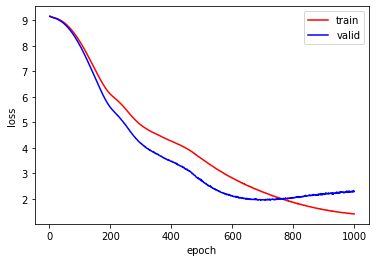

<Figure size 432x288 with 0 Axes>

In [39]:
x = np.arange(1, train_results.shape[0]+1)
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig(opt.output_dir+'/loss.png')

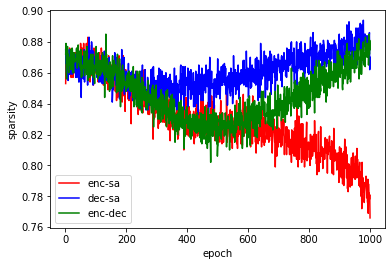

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(x, sparsity_results[:, 0], label='enc-sa', color='red')
plt.plot(x, sparsity_results[:, 1], label='dec-sa', color='blue')
plt.plot(x, sparsity_results[:, 2], label='enc-dec', color='green')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('sparsity')
plt.show()
plt.savefig(opt.output_dir+'/sparsity.png')